## Лабораторная работа № 1 
## Выполнение разведочного анализа больших данных с использованием фреймворка Apache Spark

### Часть 2

В данной части работы рассмотрены:
* разведочный анализ данных;
* работа с Dataframe API фреймворка `Apache Spark`.

Подключаем необходимые библиотеки.

In [62]:
import os
from pyspark.sql import SparkSession, DataFrame
from pyspark import SparkConf
from pyspark.sql.functions import (
    col, lit, sum, mean, when,
    explode, count, desc, floor,
    corr, array_contains, lit, first
)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Сформируем объект конфигурации для `Apache Spark`, указав необходимые параметры.

In [63]:
def create_spark_configuration() -> SparkConf:
    """
    Создает и конфигурирует экземпляр SparkConf для приложения Spark.

    Returns:
        SparkConf: Настроенный экземпляр SparkConf.
    """
    # Получаем имя пользователя
    user_name = os.getenv("USER")
    
    conf = SparkConf()
    conf.setAppName("lab 1 Test")
    conf.setMaster("yarn")
    conf.set("spark.submit.deployMode", "client")
    conf.set("spark.executor.memory", "12g")
    conf.set("spark.executor.cores", "8")
    conf.set("spark.executor.instances", "2")
    conf.set("spark.driver.memory", "4g")
    conf.set("spark.driver.cores", "2")
    conf.set("spark.jars.packages", "org.apache.iceberg:iceberg-spark-runtime-3.5_2.12:1.6.0")
    conf.set("spark.sql.extensions", "org.apache.iceberg.spark.extensions.IcebergSparkSessionExtensions")
    conf.set("spark.sql.catalog.spark_catalog", "org.apache.iceberg.spark.SparkCatalog")
    conf.set("spark.sql.catalog.spark_catalog.type", "hadoop")
    conf.set("spark.sql.catalog.spark_catalog.warehouse", f"hdfs:///user/{user_name}/warehouse")
    conf.set("spark.sql.catalog.spark_catalog.io-impl", "org.apache.iceberg.hadoop.HadoopFileIO")

    return conf

Создаём сам объект конфигурации.

In [64]:
conf = create_spark_configuration()

Создаём и выводим на экран сессию `Apache Spark`. В процессе создания сессии происходит подключение к кластеру `Apache Hadoop`, что может занять некоторое время.

In [65]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()
spark

Укажем базу данных, которая была создана в первой части лабораторной работы.

In [66]:
database_name = "skobelin_database"

Установим созданную базу данных как текущую.

In [ ]:
spark.catalog.setCurrentDatabase(database_name)

Прочитаем сохранённую в предыдущей части работы таблицу и загрузим её в `Spark Dataframe`.

In [68]:
df = spark.table("skobelin_lab1_table")

Выведем прочитанную таблицу на экран.

In [69]:
df.show()

+--------+--------------------+---------------------+---------------+-------------+----------------+---------------+----------+------------------+-----------------+----------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|pickup_longitude|pickup_latitude|RateCodeID|store_and_fwd_flag|dropoff_longitude|dropoff_latitude|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|
+--------+--------------------+---------------------+---------------+-------------+----------------+---------------+----------+------------------+-----------------+----------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|       2| 2015-01-15 21:18:42|  2015-01-15 21:24:05|              6|         0.95|       -73.99135|      40.729916|         1|                 N|        -73.99

Посмотрим на схему данных.

In [70]:
df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: float (nullable = true)
 |-- pickup_longitude: float (nullable = true)
 |-- pickup_latitude: float (nullable = true)
 |-- RateCodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- dropoff_longitude: float (nullable = true)
 |-- dropoff_latitude: float (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: float (nullable = true)
 |-- extra: float (nullable = true)
 |-- mta_tax: float (nullable = true)
 |-- tip_amount: float (nullable = true)
 |-- tolls_amount: float (nullable = true)
 |-- improvement_surcharge: float (nullable = true)
 |-- total_amount: float (nullable = true)



Вычислим количество строк в датафрейме.

In [71]:
# 12748986
# 12734170
df.count()

12748986

#### Анализ столбца `tpep_pickup_datetime`

Отсортируем датафрейм по столбцу `tpep_pickup_datetime`.

In [72]:
df.orderBy("tpep_pickup_datetime", ascending=True).show()

+--------+--------------------+---------------------+---------------+-------------+----------------+---------------+----------+------------------+-----------------+----------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|pickup_longitude|pickup_latitude|RateCodeID|store_and_fwd_flag|dropoff_longitude|dropoff_latitude|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|
+--------+--------------------+---------------------+---------------+-------------+----------------+---------------+----------+------------------+-----------------+----------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|       1| 2015-01-01 00:00:00|  2015-01-01 00:11:26|              5|          4.0|      -73.971436|        40.7602|         1|                 N|        -73.92

Удалим стоки, где время прибытия равно времени отправления.

In [73]:
df = df.filter(df.tpep_pickup_datetime != df.tpep_dropoff_datetime)

In [74]:
df.count()

12734170

Определим основные функции.

In [75]:
def count_nulls(data: DataFrame,
                column_name: str) -> None:
    """
    Подсчет количества null и not null значений в указанном столбце.

    Args:
        data (DataFrame): DataFrame, содержащий данные.
        column_name (str): Имя столбца для подсчета null и not null значений.
    
    Returns:
        None
    """
    # Подсчет количества null значений в указанном столбце
    null_counts = data.select(
        sum(col(column_name).isNull().cast("int"))
    ).collect()[0][0]

    # Подсчет количества not null значений в указанном столбце
    not_null_counts = data.select(
        sum(col(column_name).isNotNull().cast("int"))
    ).collect()[0][0]

    # Вывод результатов
    print(f"Число колонок с NULL: {null_counts} "
          f"({100 * null_counts / (null_counts + not_null_counts):.2f}%)")

#count_nulls(data=df, column_name="body_type")

def plot_cat_distribution(data: DataFrame,
                          column_name: str,
                          top_n: int = 20) -> None:
    """
    Построение распределения категориального признака.

    Args:
        data (DataFrame): DataFrame, содержащий данные.
        column_name (str): Имя столбца для группировки.
        top_n (int): Количество топ-значений для отображения.
    
    Returns:
        None
    """
    # Группировка данных по столбцу и подсчет количества
    categories = (
        data
        .groupBy(column_name)
        .count()
        .orderBy("count", ascending=False)
    )
    
    print(f"Количество категорий признака {column_name}: {categories.count()}")

    categories = (
        categories
        .limit(top_n)
        .toPandas()
    )
    
    # Визуализация с использованием Seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(x=column_name, y="count", data=categories)
    plt.title(f"Barplot of \"{column_name}\" counts")
    plt.xlabel(column_name)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

#plot_cat_distribution(data=df, column_name="body_type")

# функция на проверку наличия выбросов
def plot_boxplots(data: DataFrame,
                  columns: list[str],
                  sample_fraction: float = 0.1) -> None:
    """
    Построение boxplot для нескольких столбцов в PySpark DataFrame.

    Args:
        data (DataFrame): DataFrame, содержащий данные.
        columns (list of str): Список имен столбцов для построения boxplot.
        sample_fraction (float): Доля данных для семплирования выбросов.
    
    Returns:
        None
    """
    box_data = []

    for column in columns:
        # Вычисление квантилей
        quantiles = data.approxQuantile(column, [0.25, 0.5, 0.75], 0.01)
        q1, median, q3 = quantiles

        # Вычисление IQR и границ усов
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Фильтрация выбросов
        filtered_df = data.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))
        outliers_df = data.filter((col(column) < lower_bound) | (col(column) > upper_bound))

        # Вычисление минимального и максимального значений
        min_value = data.agg({column: "min"}).collect()[0][0]
        mean_value = data.agg({column: "mean"}).collect()[0][0]
        std_value = data.agg({column: "std"}).collect()[0][0]
        max_value = data.agg({column: "max"}).collect()[0][0]

        # Ограничение усов минимальным и максимальным значениями
        lower_bound = max(lower_bound, min_value)
        upper_bound = min(upper_bound, max_value)

        # Семплирование выбросов
        outliers = []
        if not outliers_df.isEmpty():
            sampled_outliers_df = outliers_df.sample(sample_fraction)
            outliers = (
                sampled_outliers_df
                .select(column)
                .limit(1000)
                .collect()
            )
            outliers = [row[column] for row in outliers]
            
            # Добавление минимального и максимального значений, если они 
            # относятся к выбросам и не присутствуют в семпле
            if min_value < lower_bound and min_value not in outliers:
                outliers.append(min_value)
            if max_value > upper_bound and max_value not in outliers:
                outliers.append(max_value)

        # Подготовка данных для axes.bxp
        box_data.append({
            'whislo': lower_bound,  # Нижняя граница усов
            'q1': q1,               # Первый квартиль
            'med': median,          # Медиана
            'q3': q3,               # Третий квартиль
            'whishi': upper_bound,  # Верхняя граница усов
            'fliers': outliers      # Выбросы
        })
        
    # Вывод статистических характеристик
    print(f"Минимальное значение:          {min_value:.2f}")
    print(f"Среднее значение:              {mean_value:.2f}")
    print(f"Среднеквадратичное отклонение: {std_value:.2f}")
    print(f"Первый квартиль:               {q1:.2f}")
    print(f"Медиана:                       {median:.2f}")
    print(f"Третий квартиль:               {q3:.2f}")
    print(f"Максимальное значение:         {max_value:.2f}")

    # Построение boxplot
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.bxp(box_data, 
           vert=False, 
           positions=range(1, len(columns) + 1), widths=0.5)
    ax.set_yticks(range(1, len(columns) + 1))
    ax.set_yticklabels(columns)
    ax.set_xlabel('Value')
    ax.set_title('Boxplots')
    ax.grid(True)
    plt.show()

def plot_quant_distribution(data: DataFrame,
                            column: str,
                            num_bins: int = 200) -> None:
    """
    Построение гистограммы для количественной переменной с 
    использованием PySpark и Seaborn.

    Args:
        data (DataFrame): DataFrame с данными.
        column_name (str): Название колонки с количественной переменной.
        num_bins (int): Количество бинов для гистограммы.

    Returns:
        None
    """
    # Находим минимальное и максимальное значения колонки
    min_value = data.agg({column: "min"}).collect()[0][0]
    max_value = data.agg({column: "max"}).collect()[0][0]

    # Размер бина
    bin_size = (max_value - min_value) / num_bins

    # Добавляем колонку с номером бина
    data = data.withColumn(
        "bin", 
        floor((col(column) - min_value) / bin_size)
    )

    # Группируем по номеру бина и считаем количество строк в каждом бине
    bin_counts = data.groupBy("bin").count()

    # Преобразуем результат в Pandas DataFrame для построения гистограммы
    bin_counts_pd = bin_counts.limit(1000).toPandas()
    
    # Создаем массив границ бинов
    bin_edges = [min_value + i * bin_size for i in range(num_bins + 2)]
    
    # Преобразуем номера бинов в центры бинов
    bin_centers = [
        (bin_edges[i] + bin_edges[i + 1]) / 2 for i in range(num_bins + 1)
    ]
    
    # Добавляем центры бинов в Pandas DataFrame
    bin_counts_pd['bin_center'] = bin_counts_pd['bin'].apply(
        lambda x: bin_centers[int(x)]
    )
    
    # Построение гистограммы с использованием Seaborn
    plt.figure(figsize=(20, 6))
    sns.histplot(data=bin_counts_pd, x="bin_center", 
                 weights="count", kde=True, bins=num_bins + 1)
    plt.xlabel("Value")
    plt.ylabel("Count")
    plt.title(f"Распределение количественного признака \"{column}\"")
    plt.grid(True)
    plt.show()

#### Анализ столбца `VendorID`

`VendorID` - бинарный признак.
Вычислим количество пропущенных значений.

Число колонок с NULL: 0 (0.00%)


[Row(VendorID=1), Row(VendorID=2)]


Количество категорий признака VendorID: 2


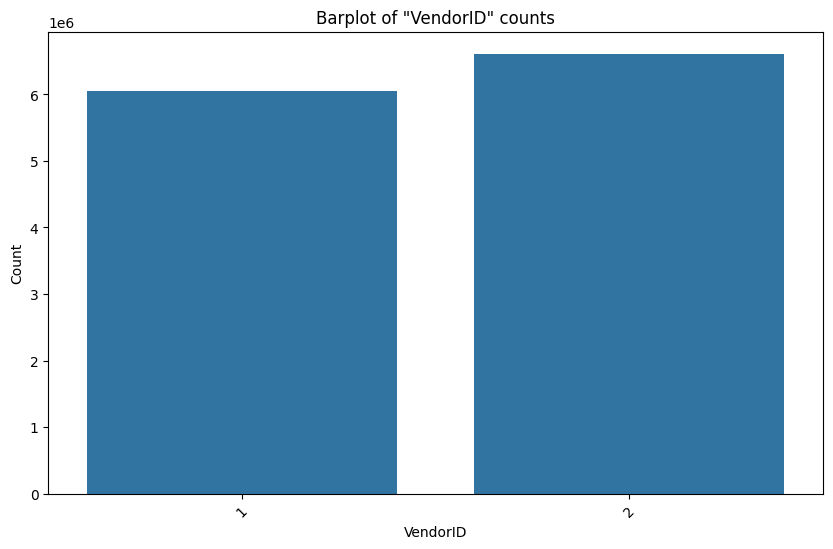

In [95]:
count_nulls(data = df, column_name = "VendorID")

print(df.select('VendorID').distinct().collect())

# визуализируем распределение
plot_cat_distribution(df, "VendorID")


#### Анализ столбца `tpep_pickup_datetime`

`tpep_pickup_datetime` - Количественный признак.
Преобразуем время в секунды.
Проверим на пропущенные значения и выбросы.

Визуализируем распределение.

Число колонок с NULL: 0 (0.00%)


Минимальное значение:          1420059600.00
Среднее значение:              1421408568.14
Среднеквадратичное отклонение: 759359.76
Первый квартиль:               1420779624.00
Медиана:                       1421394707.00
Третий квартиль:               1422028033.00
Максимальное значение:         1422737999.00


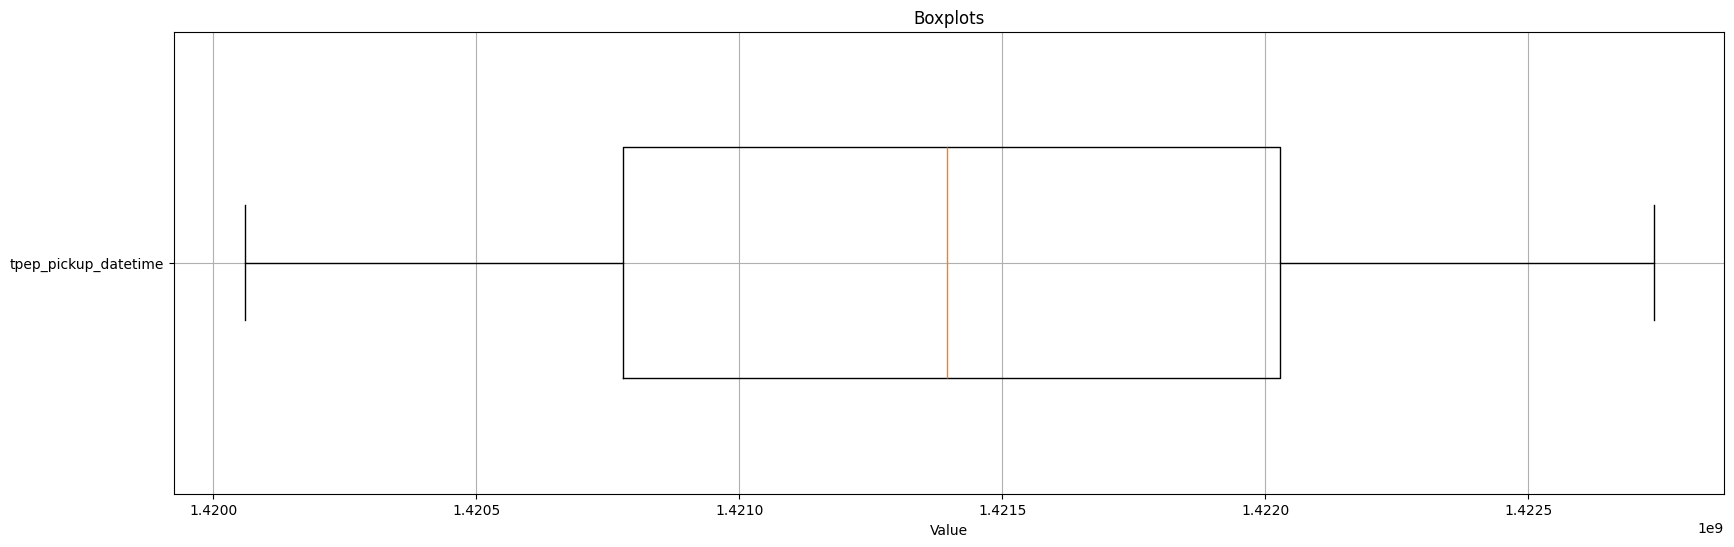

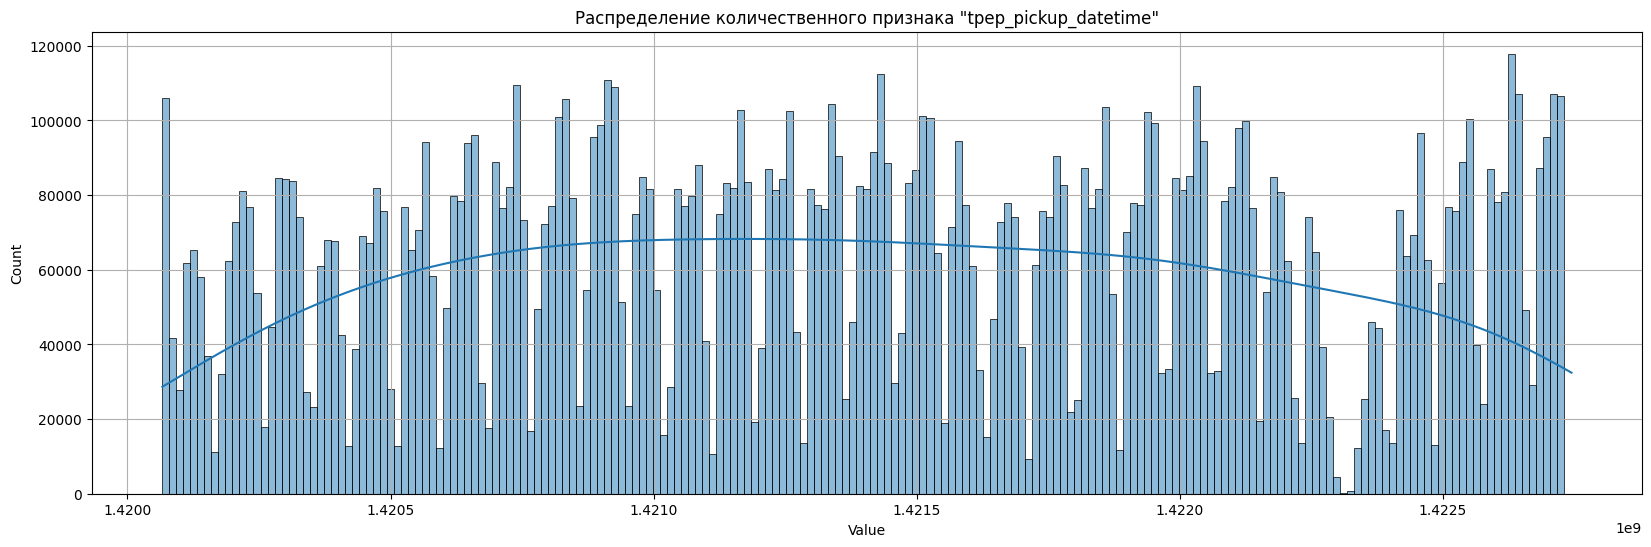

In [77]:
# tpep_pickup_datetime - количественный признак
count_nulls(data = df, column_name = "tpep_pickup_datetime")

# Преобразуем время в секунды
from pyspark.sql.functions import unix_timestamp;
df=df.withColumn('tpep_pickup_datetime', unix_timestamp(df.tpep_pickup_datetime))

# проверим на выбросы
plot_boxplots(data=df, columns=["tpep_pickup_datetime"]) # выбросов нет

# визуализируем распределение
plot_quant_distribution(data=df, column="tpep_pickup_datetime")

#### Анализ столбца `tpep_dropoff_datetime`

`tpep_pickup_datetime` - Количественный признак.
Преобразуем время в секунды.
Проверим на выбросы и пропущенные значения. Избавимся от выбросов, заменив их средним значением.

Визуализируем распределение.

Число колонок с NULL: 0 (0.00%)


Минимальное значение:          1420059648.00
Среднее значение:              1421409419.87
Среднеквадратичное отклонение: 760377.80
Первый квартиль:               1420782314.00
Медиана:                       1421395347.00
Третий квартиль:               1422028875.00
Максимальное значение:         1454419852.00


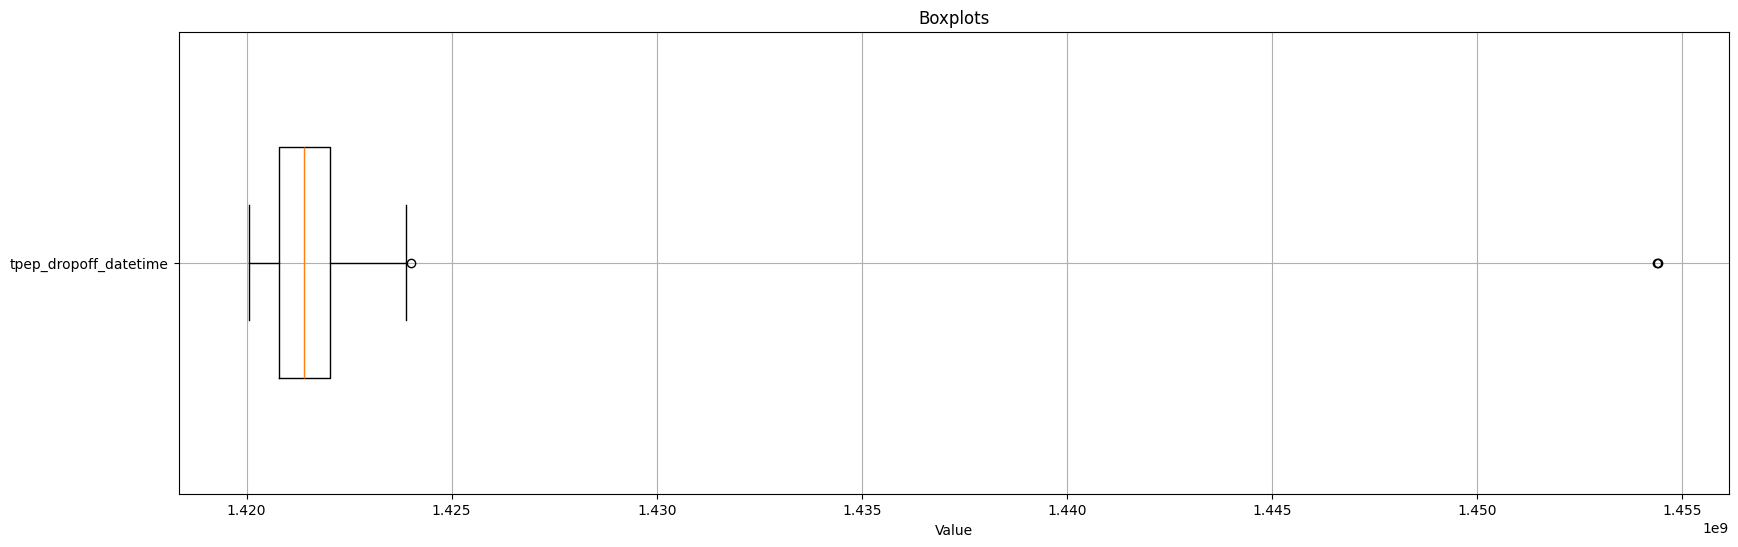

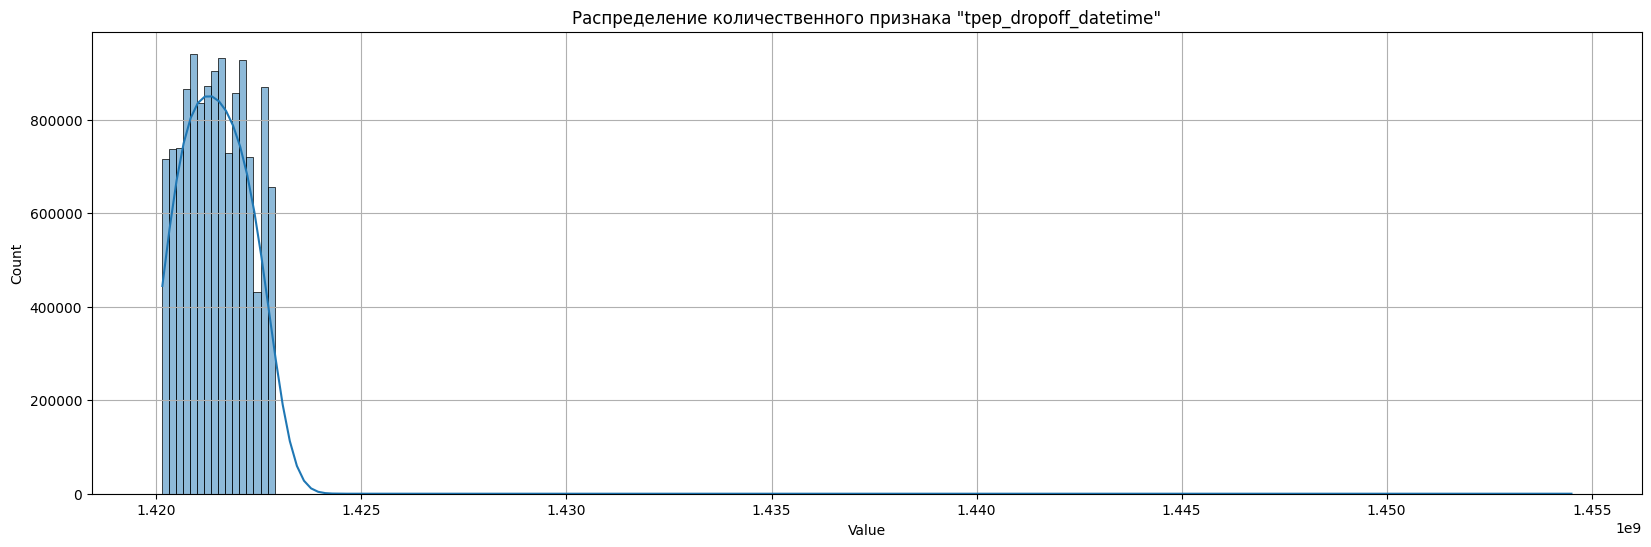

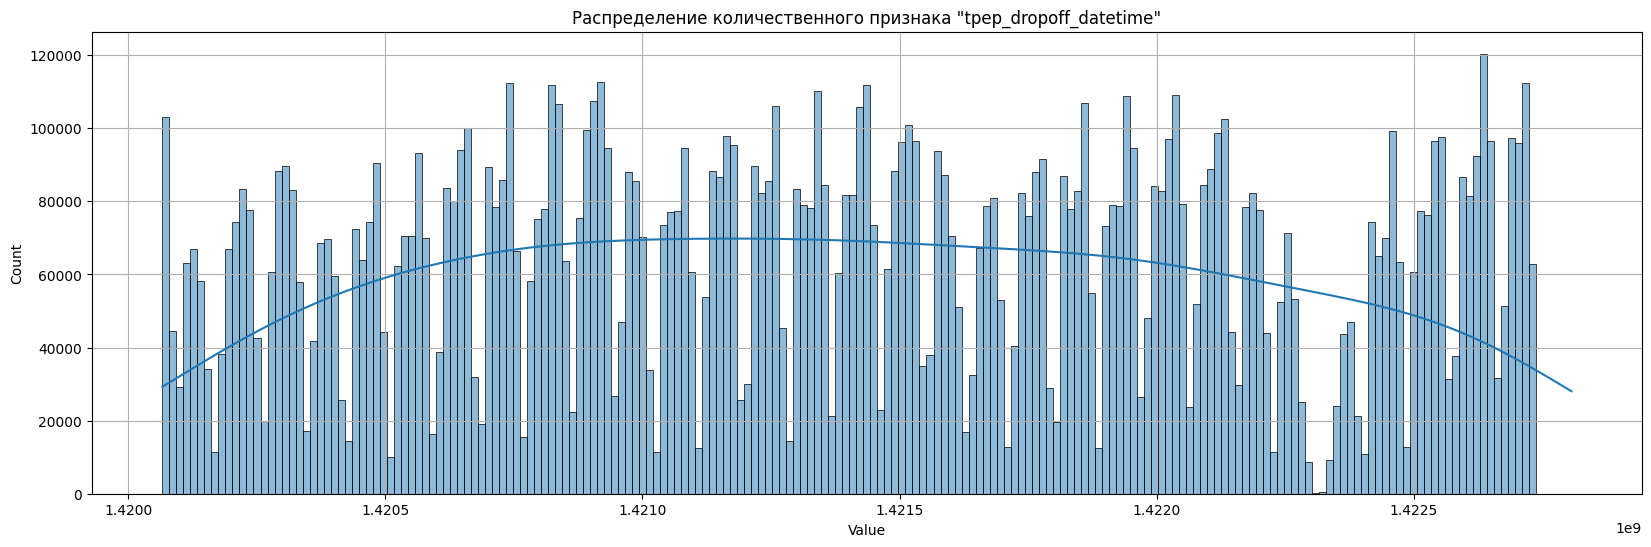

In [78]:
# Посмтортеть сколько выбросов

# tpep_dropoff_datetime - количественный признак
count_nulls(data = df, column_name = "tpep_dropoff_datetime")

# Преобразуем время в секунды
from pyspark.sql.functions import unix_timestamp;
df=df.withColumn('tpep_dropoff_datetime', unix_timestamp(df.tpep_dropoff_datetime))

# проверим на выбросы
plot_boxplots(data=df, columns=["tpep_dropoff_datetime"])

# визуализируем распределение
plot_quant_distribution(data=df, column="tpep_dropoff_datetime")

# удалим выбросы
df = df.withColumn(
    "tpep_dropoff_datetime",
    when(col("tpep_dropoff_datetime") > 1.4228e9, 1421409419.87)
        .otherwise(col("tpep_dropoff_datetime"))
)

# визуализируем распределение
plot_quant_distribution(data=df, column="tpep_dropoff_datetime")

#### Анализ столбца `passenger_count`

`passenger_count` - Количественный признак.
Проверим на выбросы и пропущенные значения. Избавимся от выбросов, заменив их максимальным значением, имеющим смысл (число пассажиров должно быть целым).

Визуализируем распределение. 

Число колонок с NULL: 0 (0.00%)


Минимальное значение:          0.00
Среднее значение:              1.68
Среднеквадратичное отклонение: 1.34
Первый квартиль:               1.00
Медиана:                       1.00
Третий квартиль:               2.00
Максимальное значение:         9.00


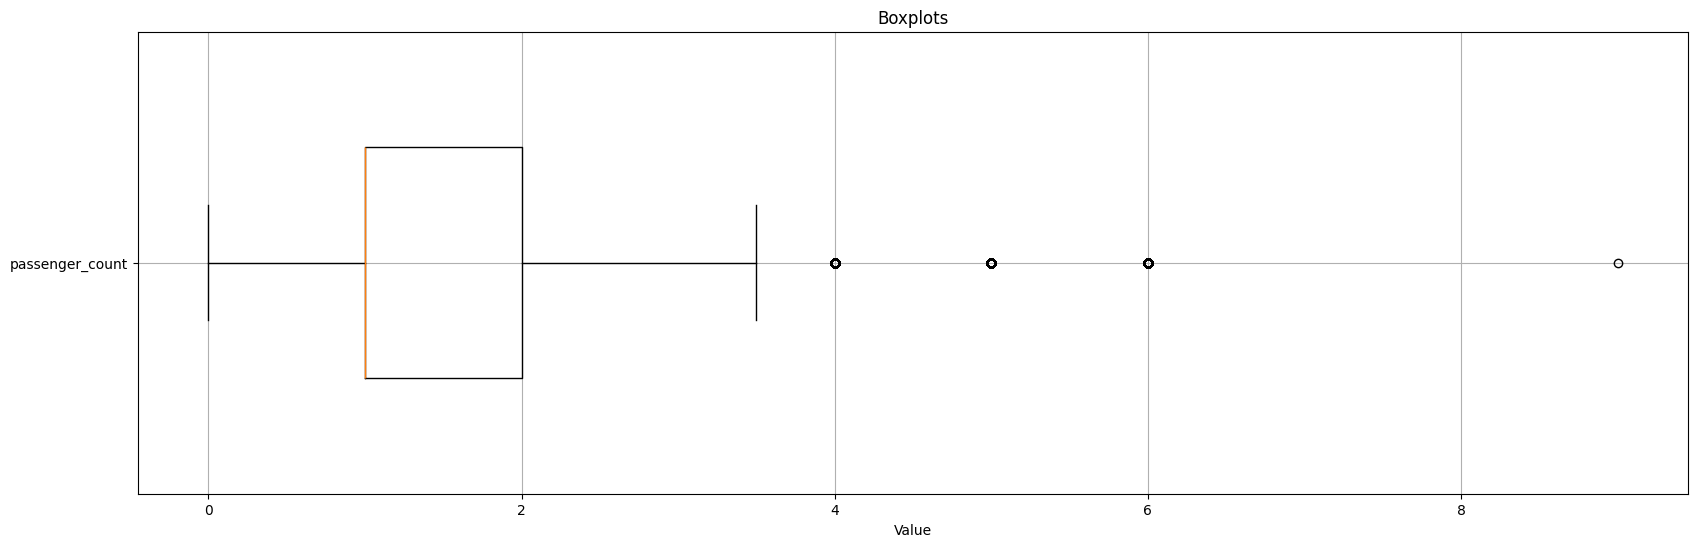

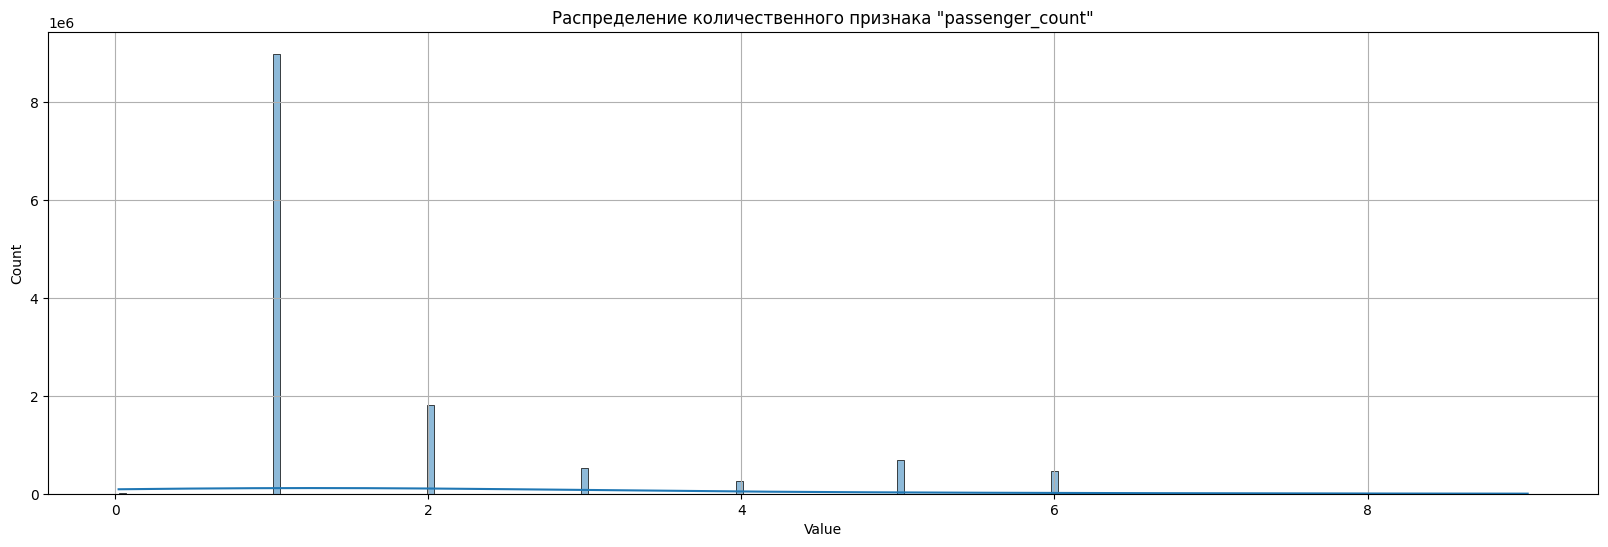

In [79]:
# Оставить выбросы

# passenger_count - количественный признак
count_nulls(data = df, column_name = "passenger_count")

# проверим на выбросы
plot_boxplots(data=df, columns=["passenger_count"])

# удалим выбросы
#df = df.withColumn(
#    "passenger_count",
#    when(col("passenger_count") > 3, 3)
#        .otherwise(col("passenger_count"))
#)

# визуализируем распределение
plot_quant_distribution(data=df, column="passenger_count")

#### Анализ столбца `trip_distance`

`trip_distance` - Количественный признак.
Проверим на выбросы и пропущенные значения. Избавимся от выбросов, логорифмировав значения.

Визуализируем распределение.

Число колонок с NULL: 0 (0.00%)


Минимальное значение:          0.00
Среднее значение:              13.47
Среднеквадратичное отклонение: 9849.82
Первый квартиль:               1.00
Медиана:                       1.66
Третий квартиль:               3.00
Максимальное значение:         15420004.00


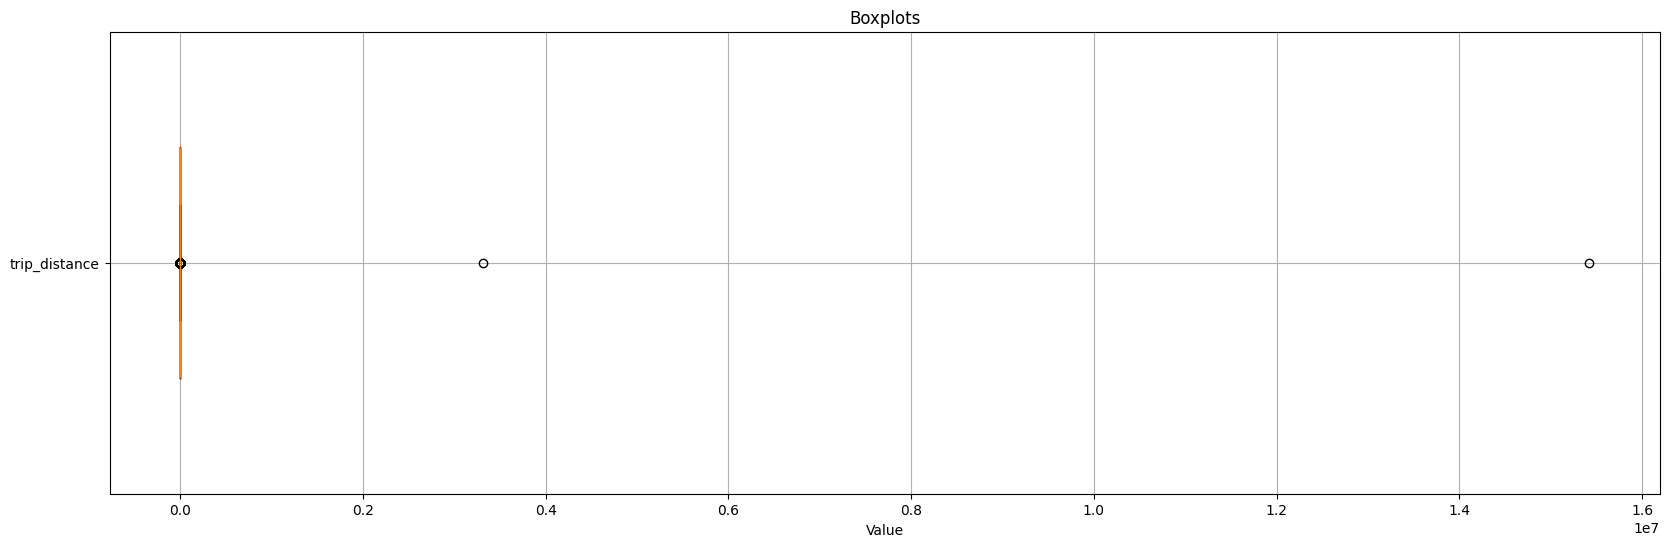

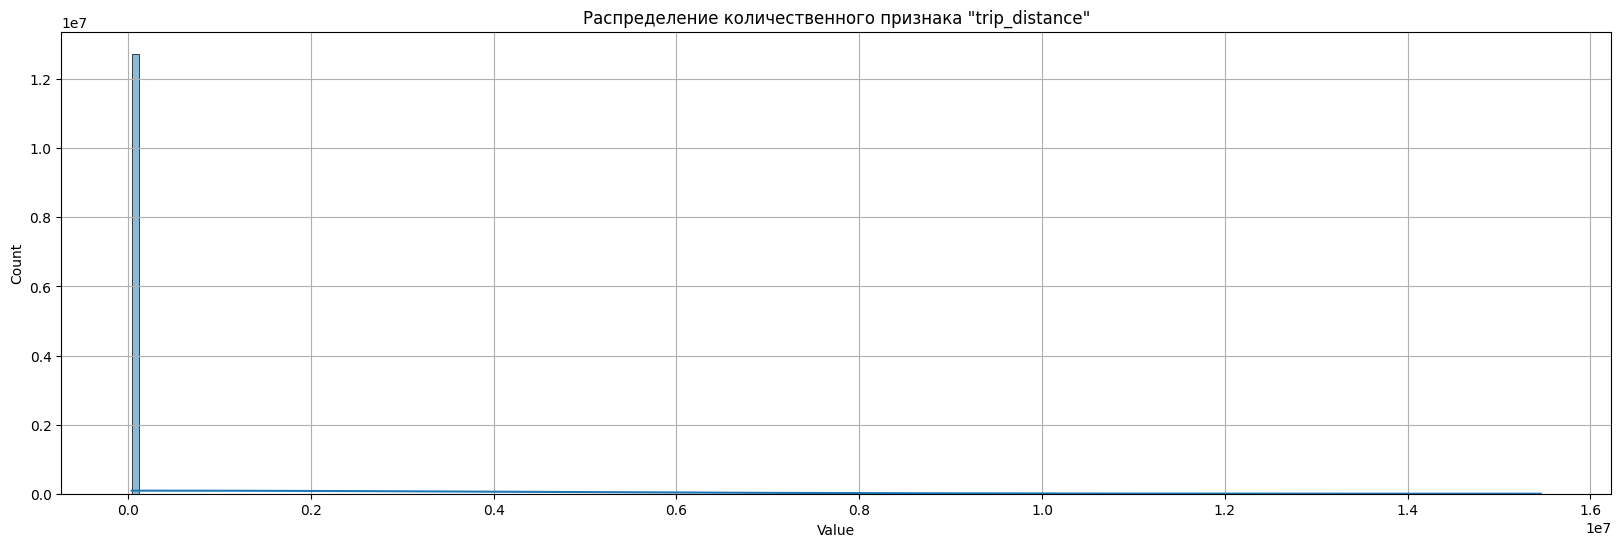

Число колонок с NULL: 65140 (0.51%)


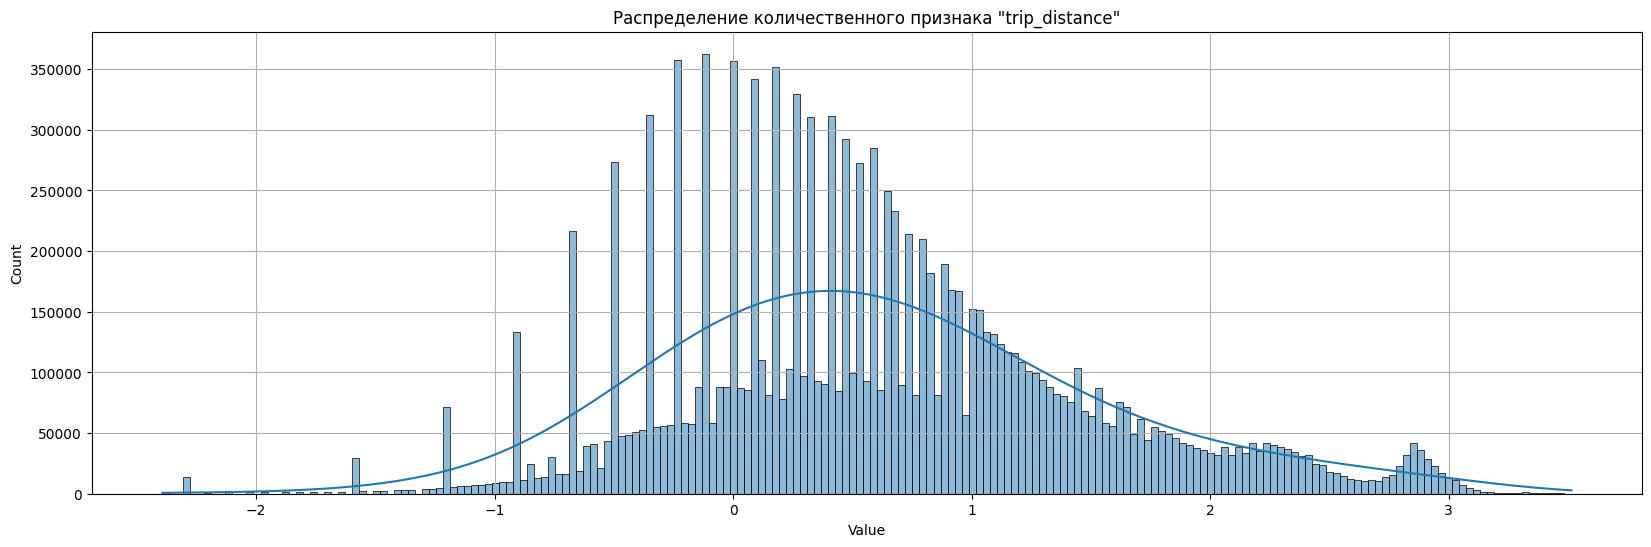

In [80]:
# trip_distance - количественный признак
count_nulls(data = df, column_name = "trip_distance")

# проверим на выбросы
plot_boxplots(data=df, columns=["trip_distance"])

# визуализируем распределение
plot_quant_distribution(data=df, column="trip_distance")

# Логарифмируем и удаляем пропущенные значения
from pyspark.sql.functions import log
df = df.withColumn("trip_distance", log(col("trip_distance")))
count_nulls(data = df, column_name = "trip_distance")
df = df.filter(df.trip_distance.isNotNull())

# удалим выбросы, заменив их средним значением
df = df.withColumn(
    "trip_distance",
    when(col("trip_distance") > 3.5, 0.6)
        .otherwise(col("trip_distance"))
)

df = df.withColumn(
    "trip_distance",
    when(col("trip_distance") < -2.5, 0.6)
        .otherwise(col("trip_distance"))
)

# визуализируем распределение
plot_quant_distribution(data=df, column="trip_distance")

#### Анализ столбца `pickup_longitude`

`pickup_longitude` - Количественный признак.
Проверим на выбросы и пропущенные значения. Избавимся от выбросов.

Визуализируем распределение.

Число колонок с NULL: 0 (0.00%)


Минимальное значение:          -119.31
Среднее значение:              -72.65
Среднеквадратичное отклонение: 9.83
Первый квартиль:               -73.99
Медиана:                       -73.98
Третий квартиль:               -73.97
Максимальное значение:         78.66


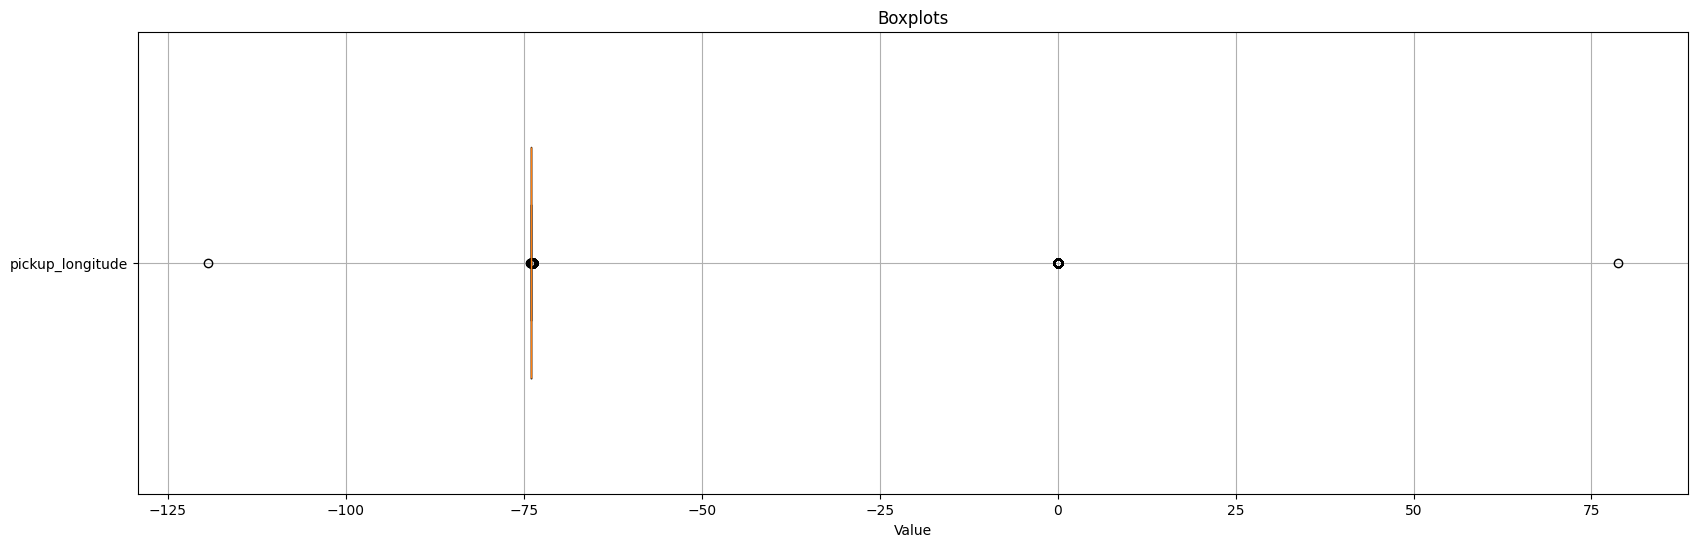

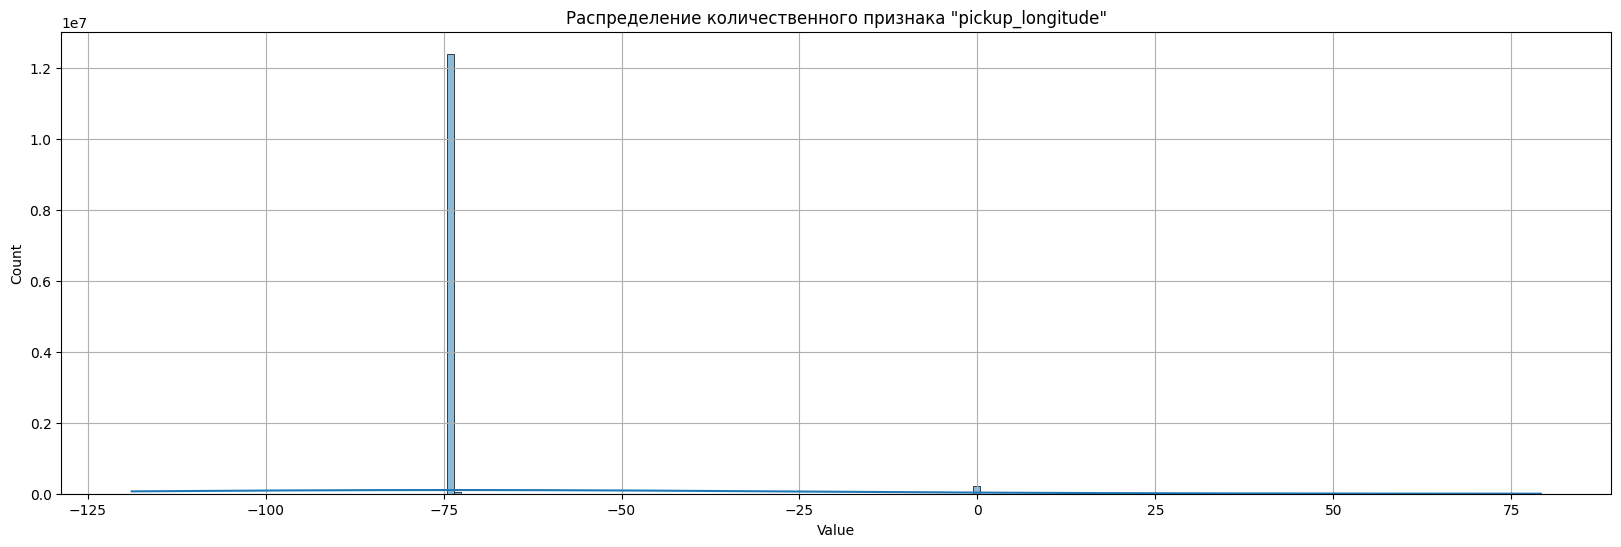

Количество категорий признака is_pickup_NY: 2


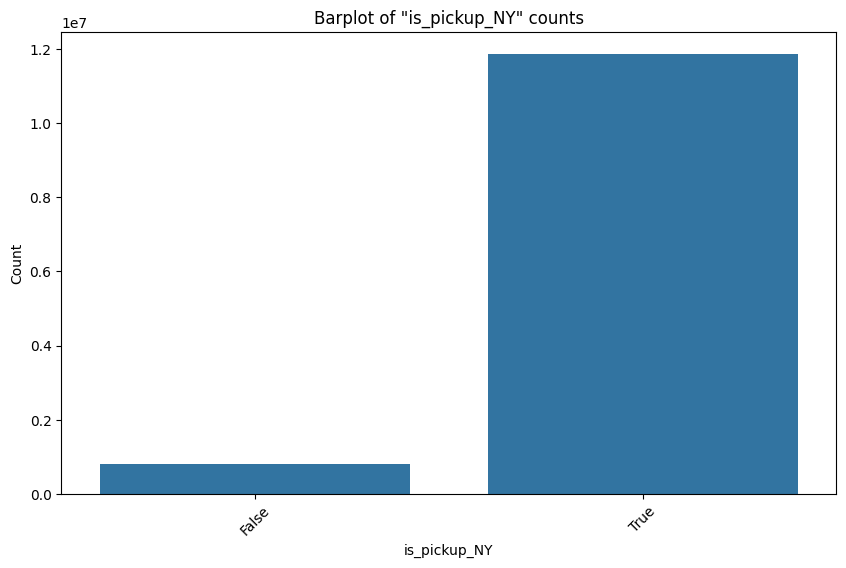

In [81]:
# Бинаризируем в зависимости от того, был ли пассажир посажен в Нью-Йорке

# pickup_longitude - количественный признак
count_nulls(data = df, column_name = "pickup_longitude")

# проверим на выбросы
plot_boxplots(data=df, columns=["pickup_longitude"])

# визуализируем распределение
plot_quant_distribution(data=df, column="pickup_longitude")

df = df.withColumn('is_pickup_NY', when(((col('pickup_longitude') >= -74.04) & (col('pickup_longitude') <= 73.92)) &
                       ((col('pickup_latitude') >= 40.7) & (col('pickup_latitude') <= 40.80)), True)
                       .otherwise(False))


# Построим функцию распределения
plot_cat_distribution(df, "is_pickup_NY")

# Удалим ненужные столбцы
df = df.drop("pickup_longitude")
df = df.drop("pickup_latitude")

#### Анализ столбца `pickup_latitude`

`pickup_latitude` - Количественный признак.
Проверим на выбросы и пропущенные значения. Избавимся от выбросов.

Визуализируем распределение.

Число колонок с NULL: 0 (0.00%)


Минимальное значение:          0.00
Среднее значение:              40.02
Среднеквадратичное отклонение: 5.41
Первый квартиль:               40.74
Медиана:                       40.75
Третий квартиль:               40.77
Максимальное значение:         404.70


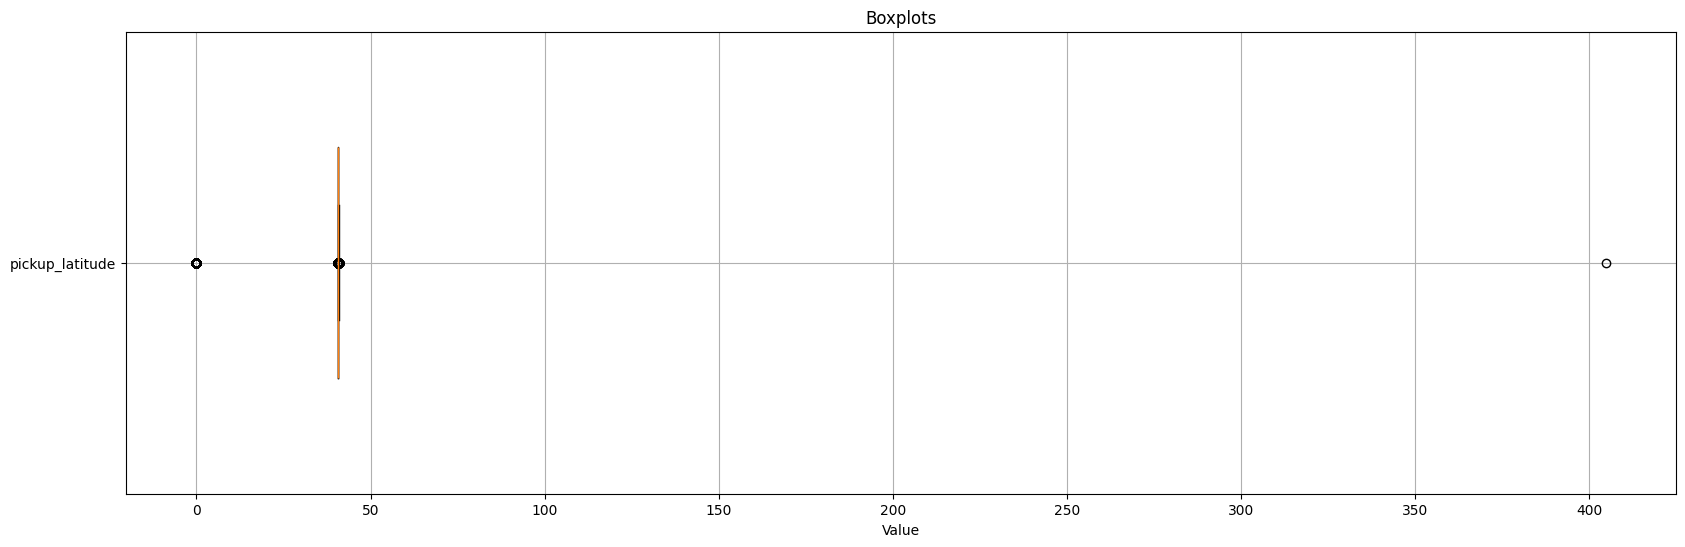

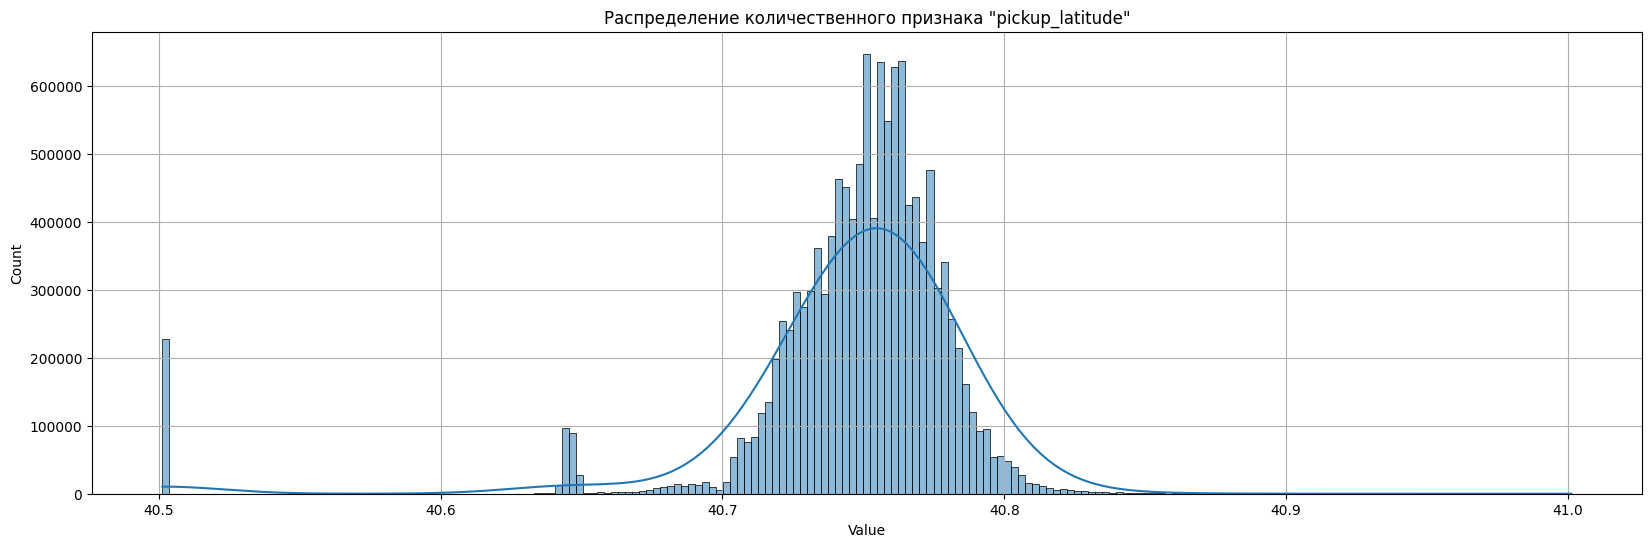

In [ ]:
# pickup_latitude - количественный признак
#count_nulls(data = df, column_name = "pickup_latitude")

# проверим на выбросы
#plot_boxplots(data=df, columns=["pickup_latitude"])

# удалим выбросы
#df = df.withColumn(
#    "pickup_latitude",
#    when(col("pickup_latitude") > 41.0, 41.0)
#        .otherwise(col("pickup_latitude"))
#)

#df = df.withColumn(
#    "pickup_latitude",
#    when(col("pickup_latitude") < 40.5, 40.5)
#        .otherwise(col("pickup_latitude"))
#)

# визуализируем распределение
#plot_quant_distribution(data=df, column="pickup_latitude")

#### Анализ столбца `RateCodeID`

`RateCodeID` - Категориальный признак.
Проверим на наличие пропущенных значений и построим функцию распределения.

[Row(RateCodeID=1), Row(RateCodeID=6), Row(RateCodeID=3), Row(RateCodeID=5), Row(RateCodeID=4), Row(RateCodeID=2), Row(RateCodeID=99)]


Число колонок с NULL: 0 (0.00%)


Количество категорий признака RateCodeID: 7


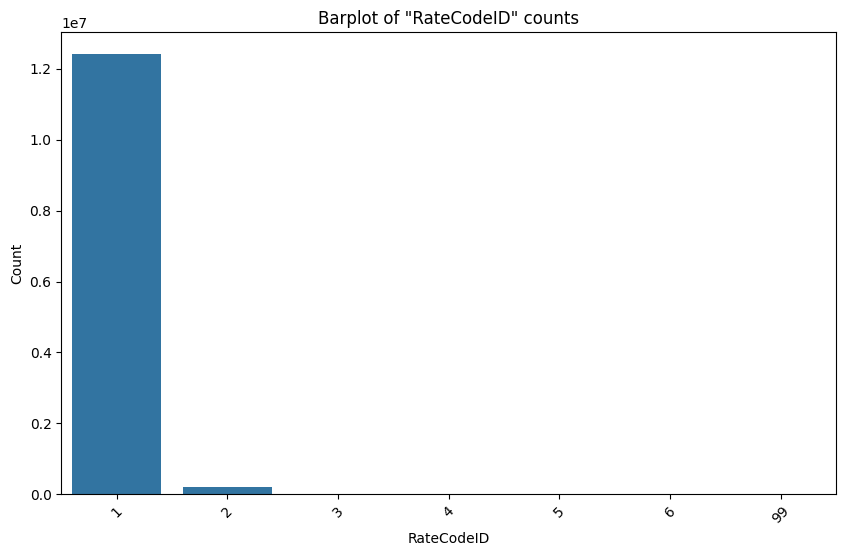

Количество категорий признака RateCodeID: 2


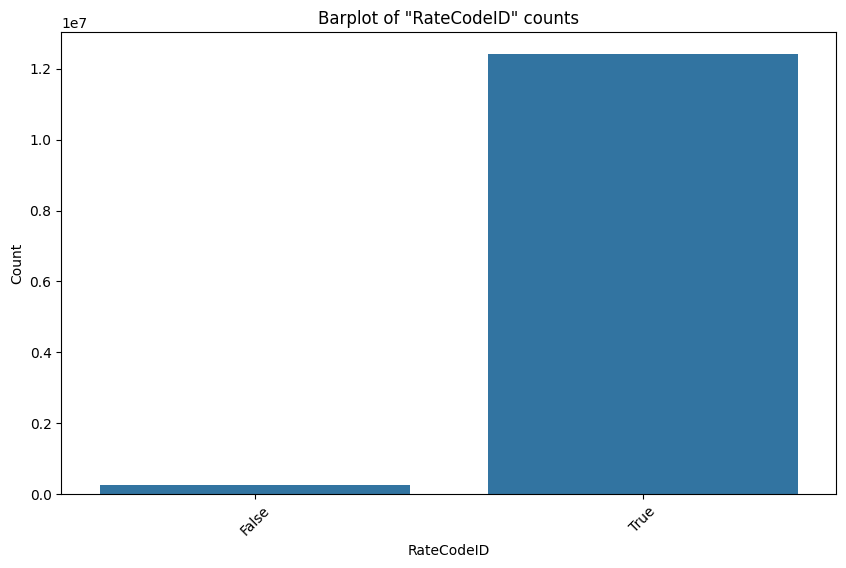

In [82]:
# бинаризировать

# Смотрим сколько всего значений может принимать атрибут
print(df.select('RateCodeID').distinct().collect())

# RateCodeID - категориальный признак
count_nulls(data = df, column_name = "RateCodeID")

plot_cat_distribution(df, "RateCodeID")

# бинаризируем
df = df.withColumn('RateCodeID', when((col('RateCodeID') == 1), True)
                       .otherwise(False))

# Построим функцию распределения
plot_cat_distribution(df, "RateCodeID")

#### Анализ столбца `store_and_fwd_flag`

`store_and_fwd_flag` - Категориальный признак.
Проверим на наличие пропущенных значений и построим функцию распределения.

[Row(store_and_fwd_flag='Y'), Row(store_and_fwd_flag='N')]


Число колонок с NULL: 0 (0.00%)


Количество категорий признака store_and_fwd_flag: 2


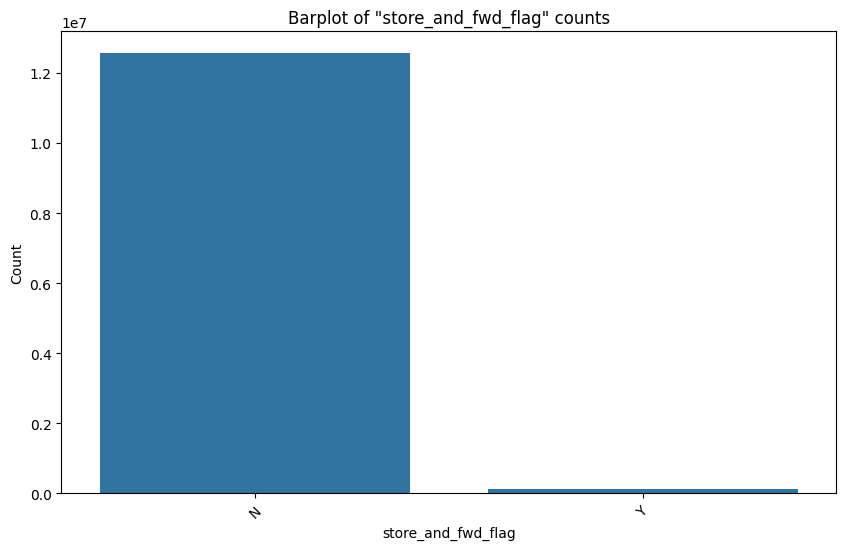

In [83]:
# Смотрим сколько всего значений может принимать атрибут
print(df.select('store_and_fwd_flag').distinct().collect())

# store_and_fwd_flag - категориальный признак
count_nulls(data = df, column_name = "store_and_fwd_flag")

# Построим функцию распределения
plot_cat_distribution(df, "store_and_fwd_flag")


#### Анализ столбца `dropoff_longitude`

`dropoff_longitude` - Количественный признак.
Проверим на выбросы и пропущенные значения. Избавимся от выбросов.

Визуализируем распределение.

Число колонок с NULL: 0 (0.00%)


Минимальное значение:          -740.17
Среднее значение:              -72.77
Среднеквадратичное отклонение: 9.38
Первый квартиль:               -73.99
Медиана:                       -73.98
Третий квартиль:               -73.96
Максимальное значение:         85.27


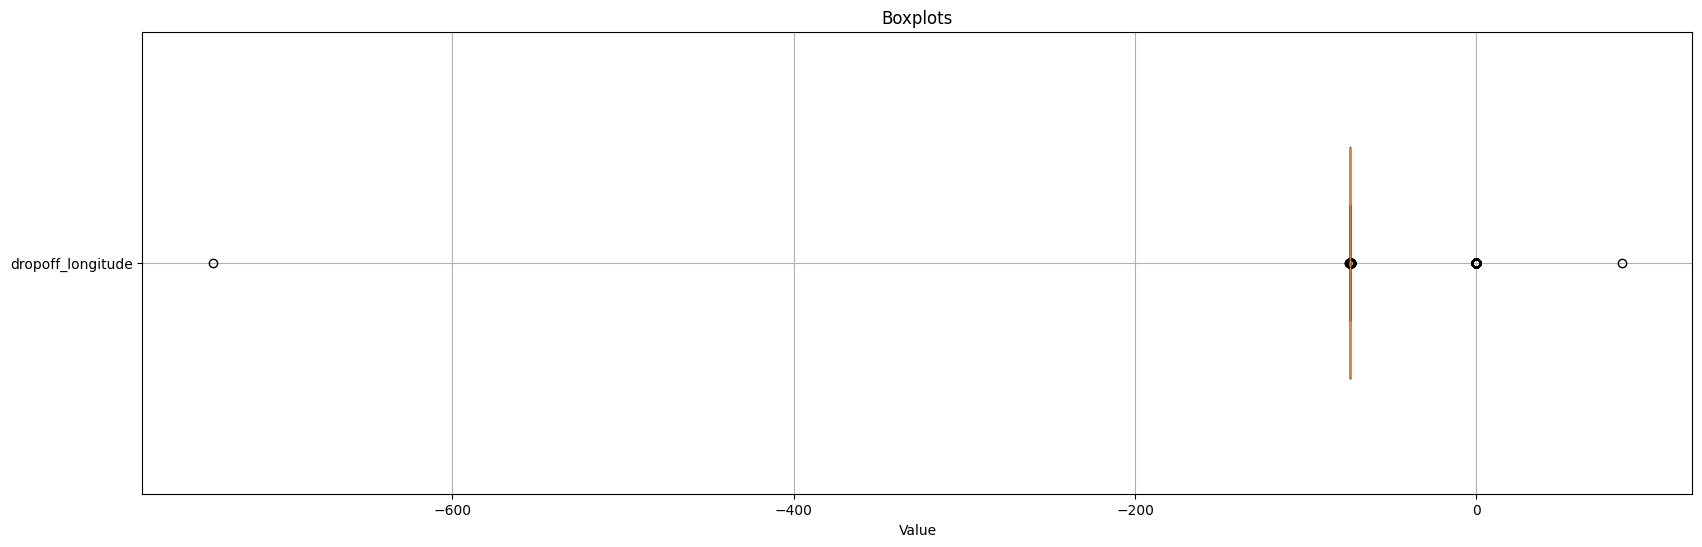

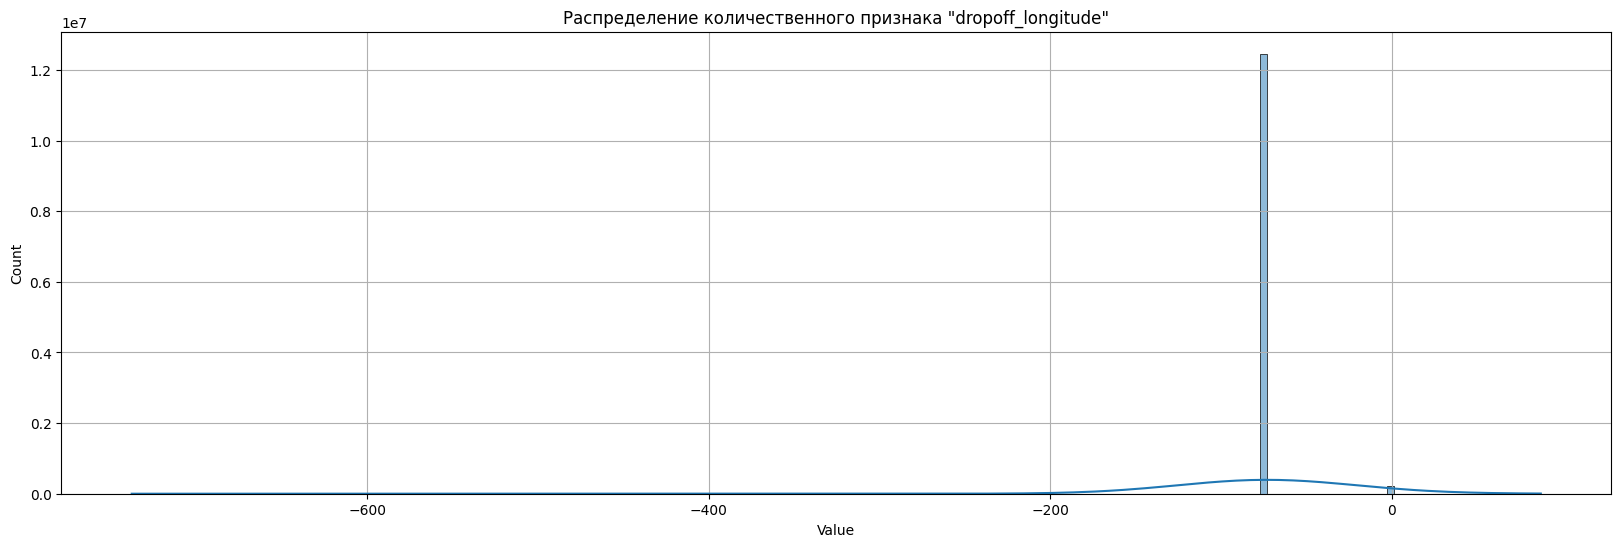

Количество категорий признака is_dropoff_NY: 2


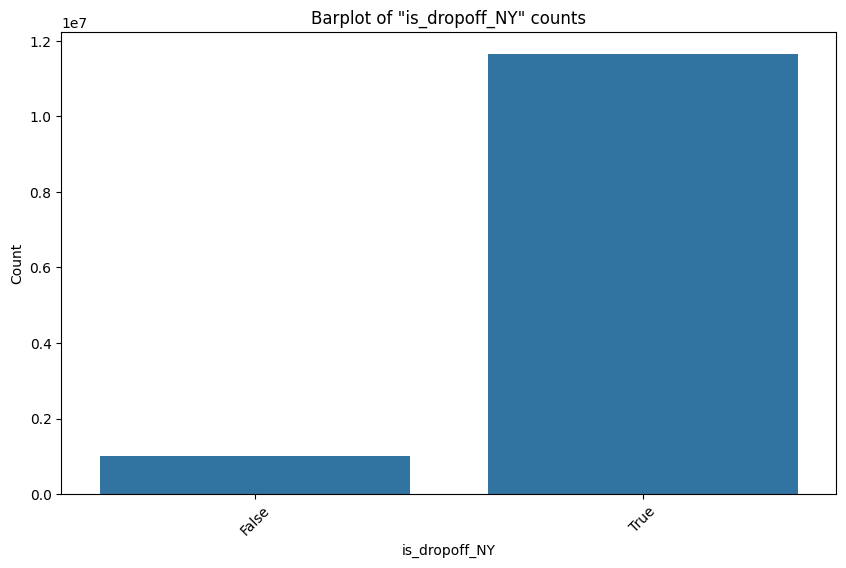

In [84]:
# dropoff_longitude - количественный признак
count_nulls(data = df, column_name = "dropoff_longitude")

# проверим на выбросы
plot_boxplots(data=df, columns=["dropoff_longitude"])

# визуализируем распределение
plot_quant_distribution(data=df, column="dropoff_longitude")

df = df.withColumn('is_dropoff_NY', when(((col('dropoff_longitude') >= -74.04) & (col('dropoff_longitude') <= 73.92)) &
                       ((col('dropoff_latitude') >= 40.68) & (col('dropoff_latitude') <= 40.80)), True)
                       .otherwise(False))

# Построим функцию распределения
plot_cat_distribution(df, "is_dropoff_NY")

# Удалим ненужные столбцы
df = df.drop("dropoff_longitude")
df = df.drop("dropoff_latitude")

#### Анализ столбца `dropoff_latitude`

`dropoff_latitude` - Количественный признак.
Проверим на выбросы и пропущенные значения. Избавимся от выбросов.

Визуализируем распределение.

Число колонок с NULL: 0 (0.00%)


Минимальное значение:          -9.03
Среднее значение:              40.09
Среднеквадратичное отклонение: 5.17
Первый квартиль:               40.73
Медиана:                       40.75
Третий квартиль:               40.77
Максимальное значение:         459.53


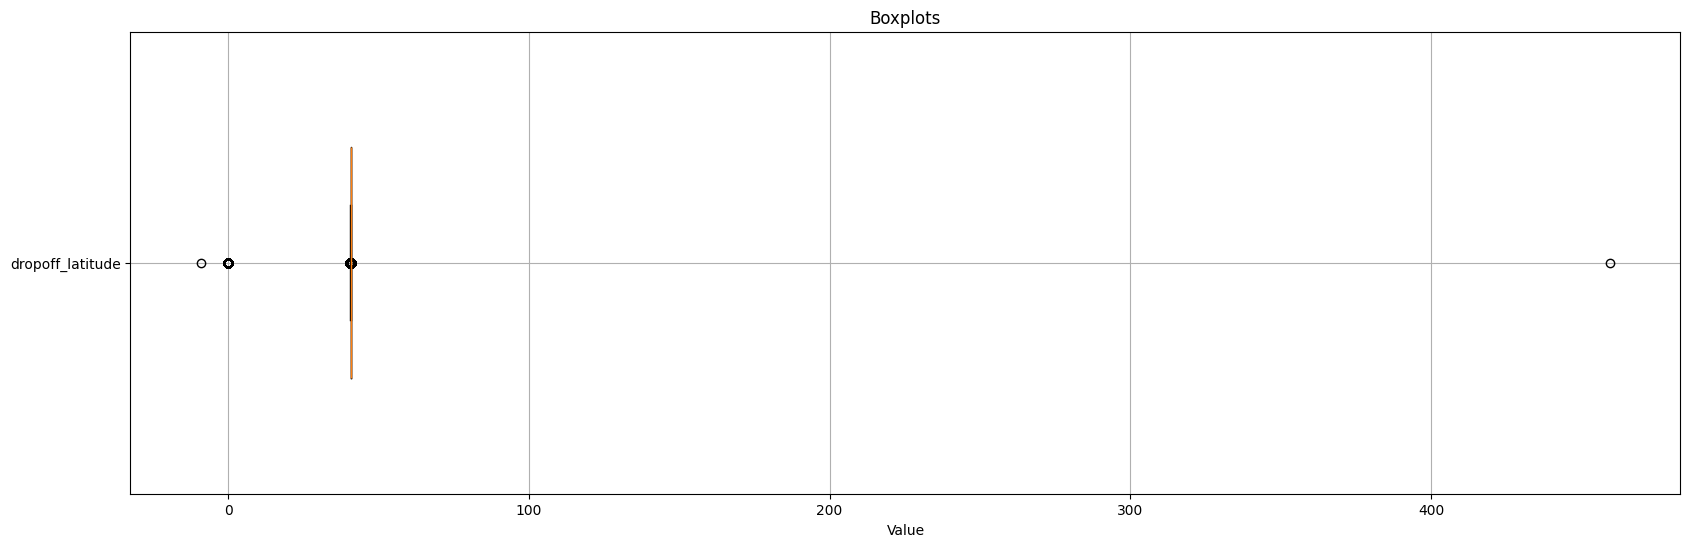

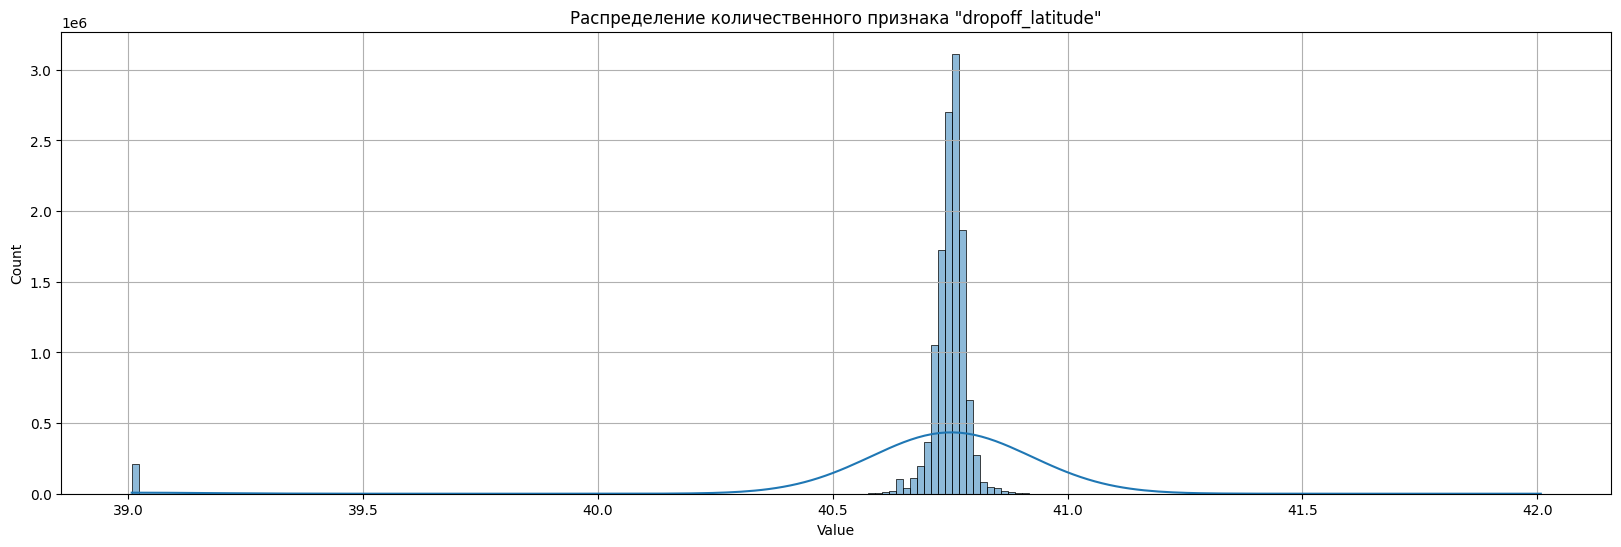

In [ ]:
# dropoff_latitude - количественный признак
#count_nulls(data = df, column_name = "dropoff_latitude")

# проверим на выбросы
#plot_boxplots(data=df, columns=["dropoff_latitude"])

# удалим выбросы
#df = df.withColumn(
#    "dropoff_latitude",
#    when(col("dropoff_latitude") > 42.0, 42.0)
#        .otherwise(col("dropoff_latitude"))
#)

#df = df.withColumn(
#    "dropoff_latitude",
#    when(col("dropoff_latitude") < 39.0, 39.0)
#        .otherwise(col("dropoff_latitude"))
#)

# визуализируем распределение
#plot_quant_distribution(data=df, column="dropoff_latitude")

#### Анализ столбца `payment_type`

`payment_type` - Категориальный признак.
Проверим на наличие пропущенных значений и построим функцию распределения.

[Row(payment_type=1), Row(payment_type=3), Row(payment_type=4), Row(payment_type=2), Row(payment_type=5)]


Число колонок с NULL: 0 (0.00%)


Количество категорий признака payment_type: 3


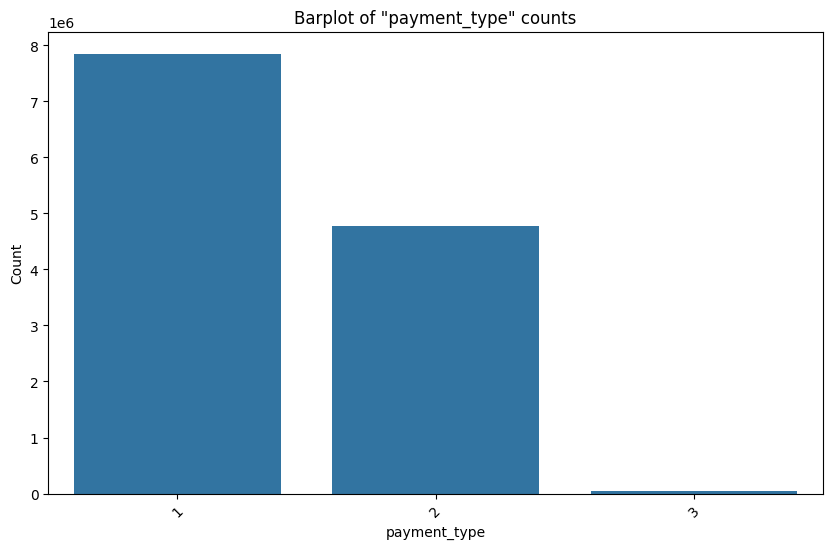

In [85]:
# Разделить на 3

# Смотрим сколько всего значений может принимать атрибут
print(df.select('payment_type').distinct().collect())

# store_and_fwd_flag - категориальный признак
count_nulls(data = df, column_name = "payment_type")

# приравниваем 4-ый и 5-ый методы оплаты к 3-му
df = df.withColumn(
    "payment_type",
    when(col("payment_type") > 3, 3)
        .otherwise(col("payment_type"))
)

# Построим функцию распределения
plot_cat_distribution(df, "payment_type")

#### Анализ столбца `fare_amount`

`fare_amount` - Количественный признак.
Проверим на выбросы и пропущенные значения. Избавимся от выбросов, логорифмировав значения.

Визуализируем распределение.

Число колонок с NULL: 0 (0.00%)


Минимальное значение:          -242.25
Среднее значение:              11.86
Среднеквадратичное отклонение: 9.87
Первый квартиль:               6.50
Медиана:                       9.00
Третий квартиль:               13.50
Максимальное значение:         4008.00


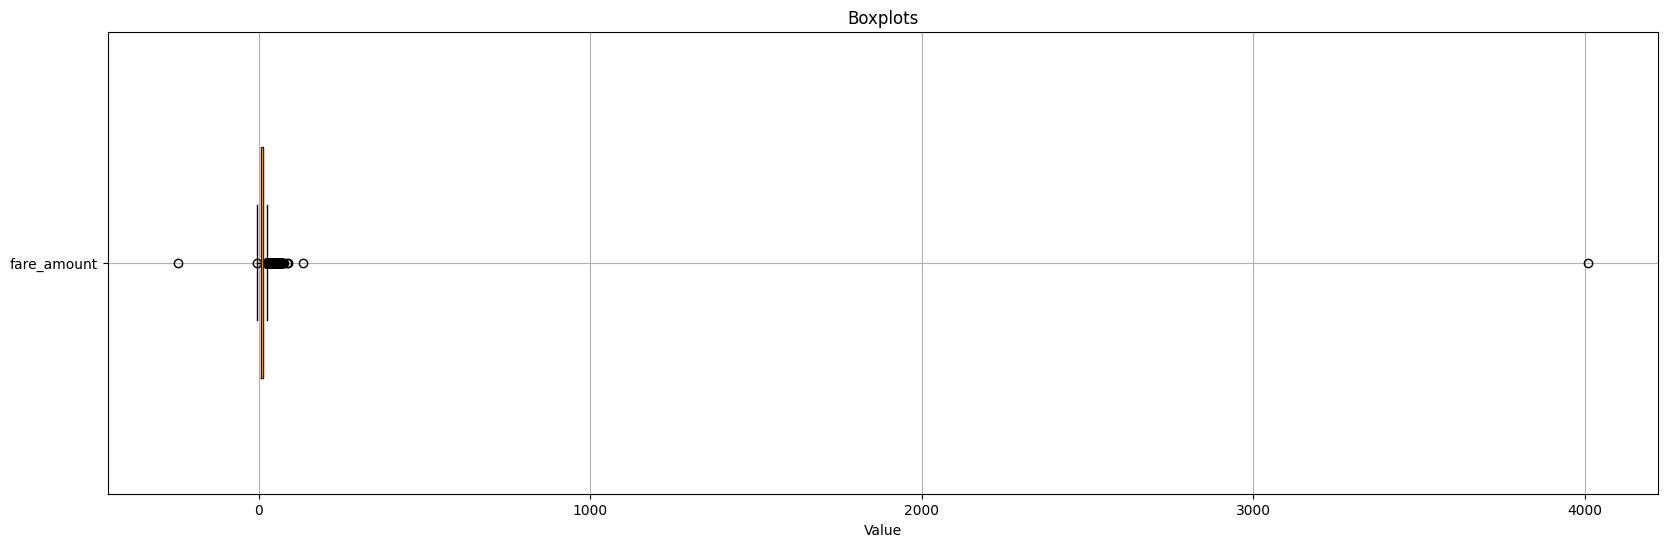

Число колонок с NULL: 5025 (0.04%)


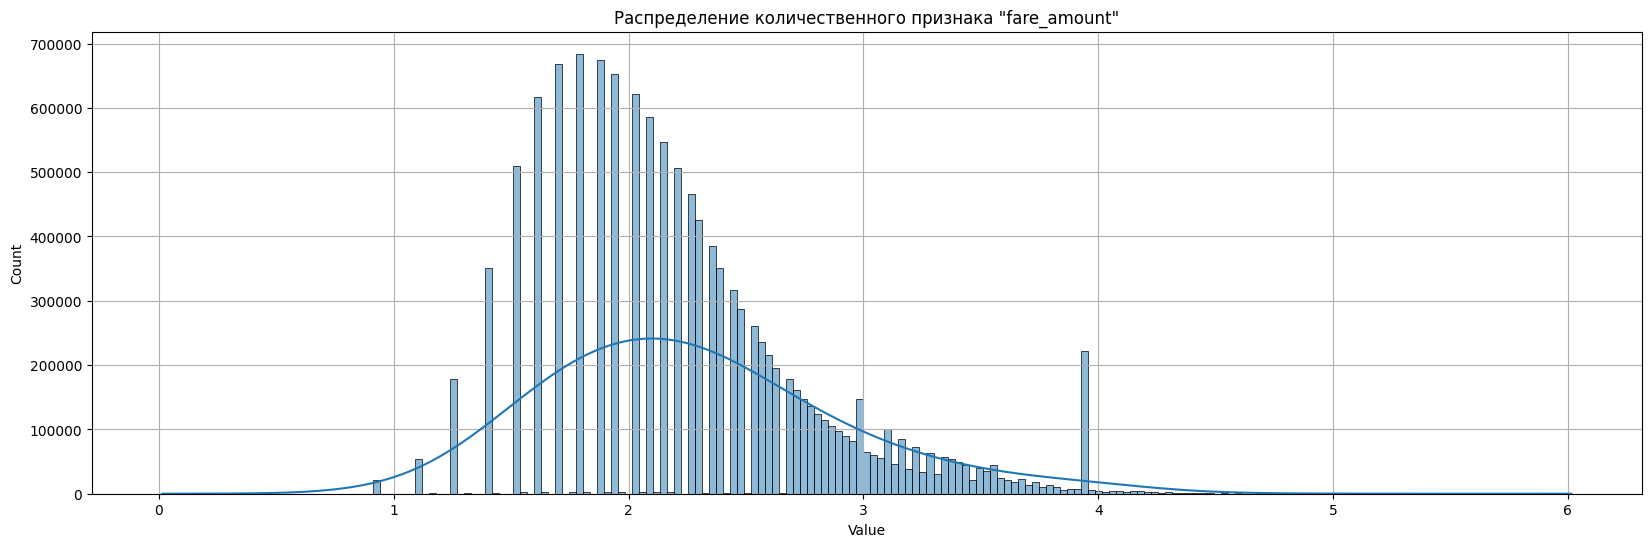

In [86]:
# fare_amount - количественный признак
count_nulls(data = df, column_name = "fare_amount")

# проверим на выбросы
plot_boxplots(data=df, columns=["fare_amount"])

# логарифмируем
df = df.withColumn("fare_amount", log(col("fare_amount")))
count_nulls(data = df, column_name = "fare_amount")
df = df.filter(df.fare_amount.isNotNull())

# удалим выбросы
df = df.withColumn(
    "fare_amount",
    when(col("fare_amount") > 6.0, 6.0)
        .otherwise(col("fare_amount"))
)

df = df.withColumn(
    "fare_amount",
    when(col("fare_amount") < 0.0, 0.0)
        .otherwise(col("fare_amount"))
)

# визуализируем распределение
plot_quant_distribution(data=df, column="fare_amount")

#### Анализ столбца `extra`

`extra` - Количественный признак.

Данный столбец не несёт существенной информации, поэтому удалим его

Число колонок с NULL: 0 (0.00%)


Минимальное значение:          -79.00
Среднее значение:              0.31
Среднеквадратичное отклонение: 0.51
Первый квартиль:               0.00
Медиана:                       0.00
Третий квартиль:               0.50
Максимальное значение:         648.02


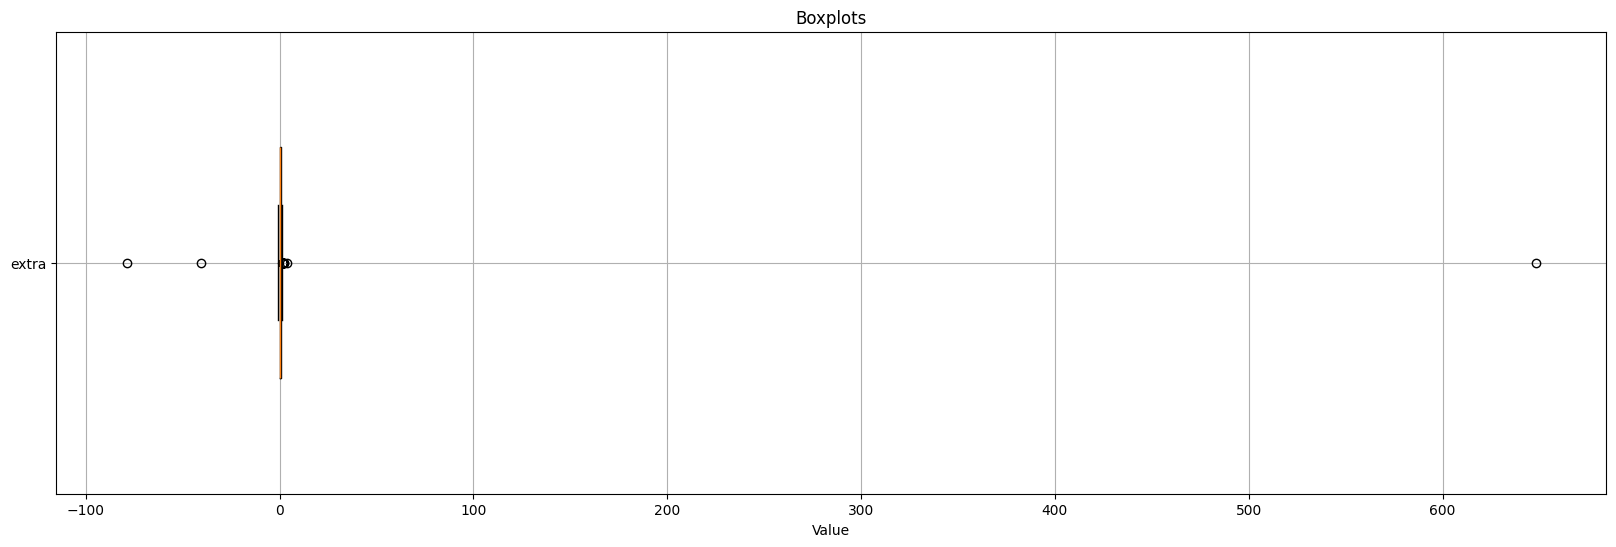

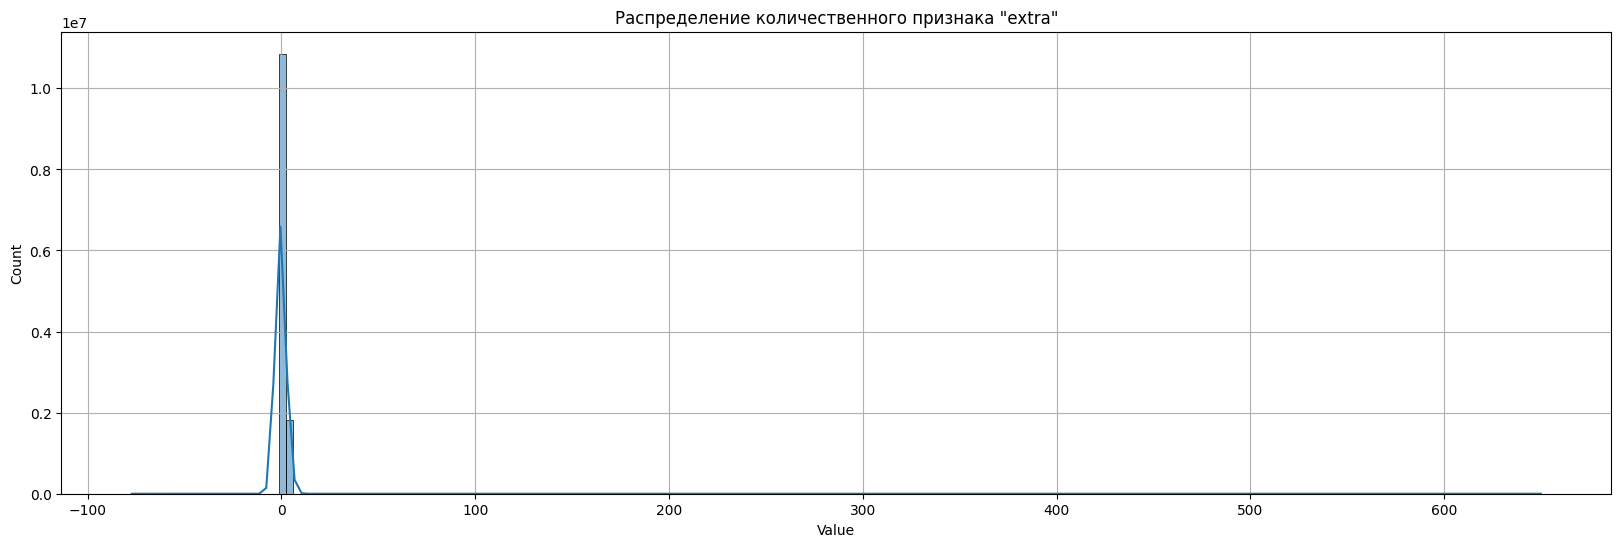

In [87]:
# extra - количественный признак
count_nulls(data = df, column_name = "extra")

# проверим на выбросы
plot_boxplots(data=df, columns=["extra"])

# визуализируем распределение
plot_quant_distribution(data=df, column="extra")

df = df.drop("extra")

#### Анализ столбца `mta_tax`

`mta_tax` - Количественный признак.

Данный столбец не несёт существенной информации, поэтому удалим его

Число колонок с NULL: 0 (0.00%)


Минимальное значение:          0.00
Среднее значение:              0.50
Среднеквадратичное отклонение: 0.02
Первый квартиль:               0.50
Медиана:                       0.50
Третий квартиль:               0.50
Максимальное значение:         0.50


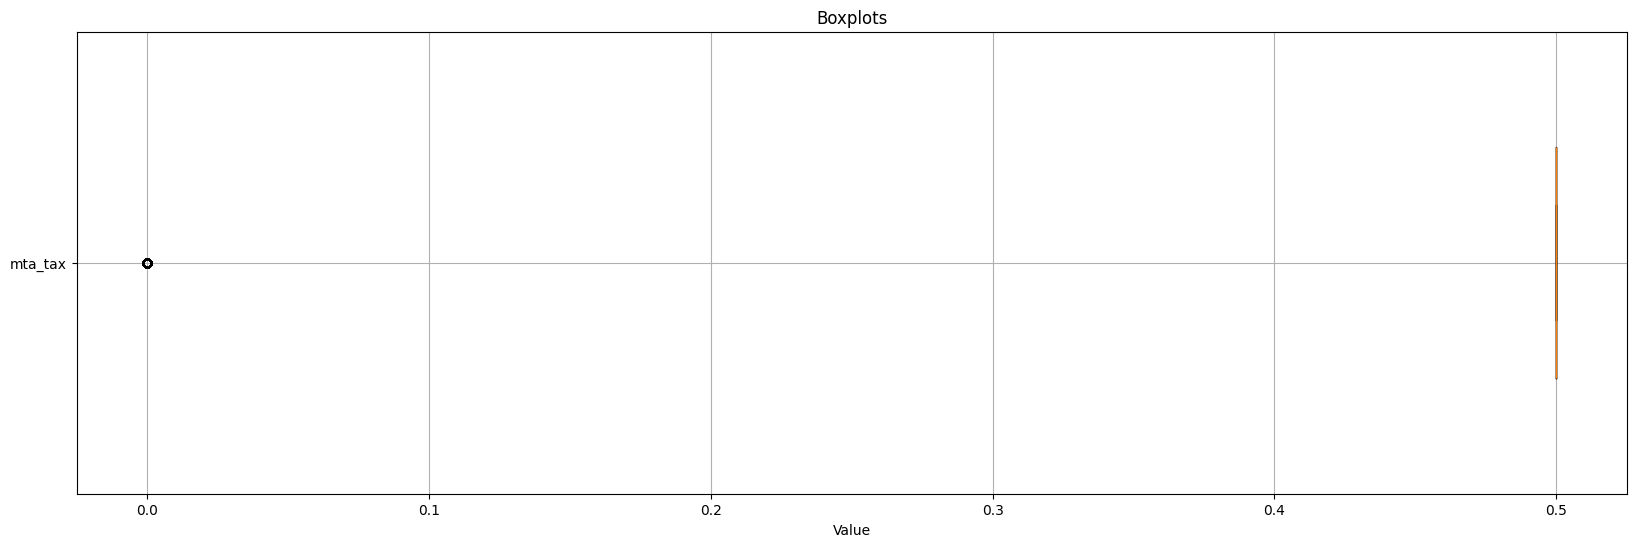

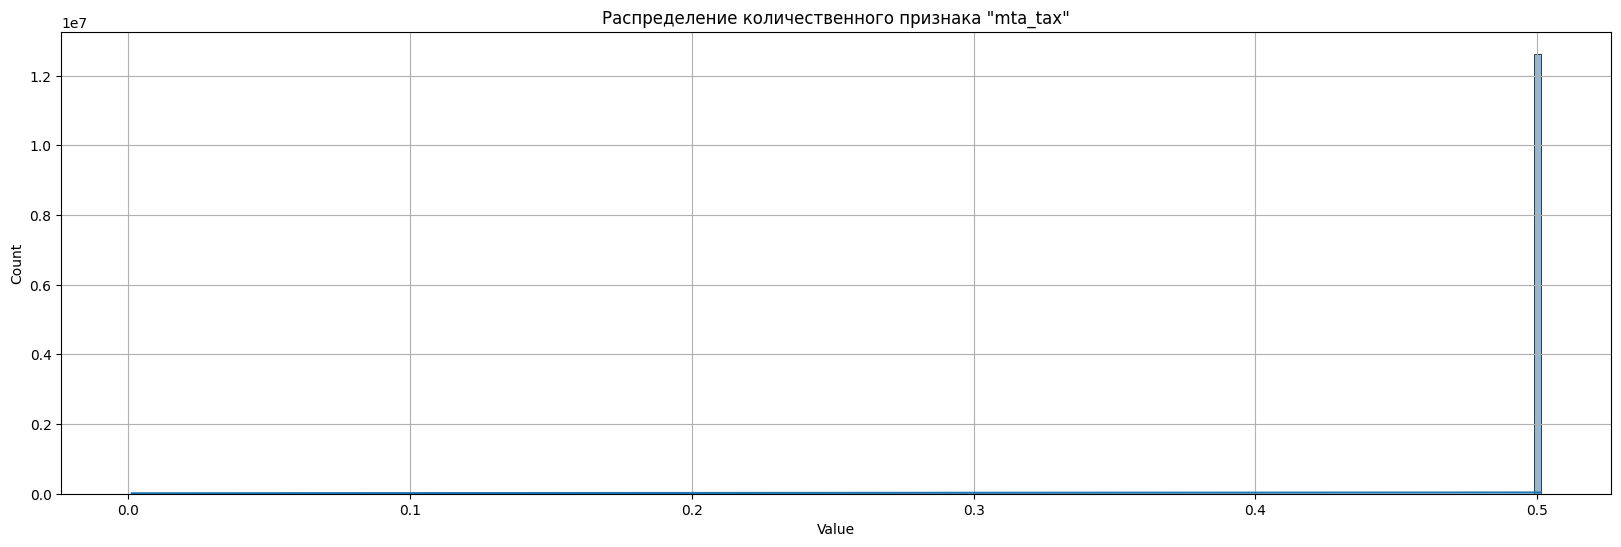

In [88]:
# mta_tax - количественный признак
count_nulls(data = df, column_name = "mta_tax")

# проверим на выбросы
plot_boxplots(data=df, columns=["mta_tax"])

# визуализируем распределение
plot_quant_distribution(data=df, column="mta_tax")

df = df.drop("mta_tax")

#### Анализ столбца `tip_amount`

`tip_amount` - Количественный признак.
Проверим на выбросы и пропущенные значения. Избавимся от выбросов.

Визуализируем распределение.

Число колонок с NULL: 0 (0.00%)


Минимальное значение:          -92.42
Среднее значение:              1.85
Среднеквадратичное отклонение: 1106.43
Первый квартиль:               0.00
Медиана:                       1.00
Третий квартиль:               2.06
Максимальное значение:         3950588.75


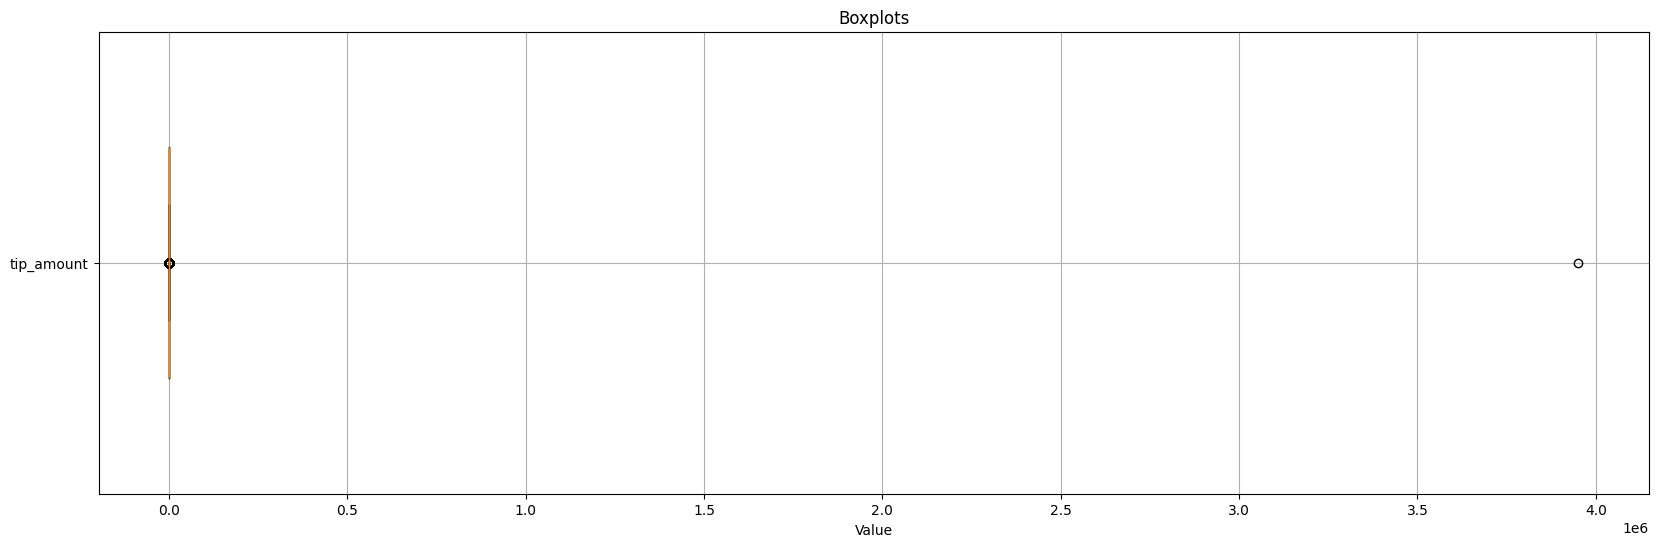

Число колонок с NULL: 0 (0.00%)


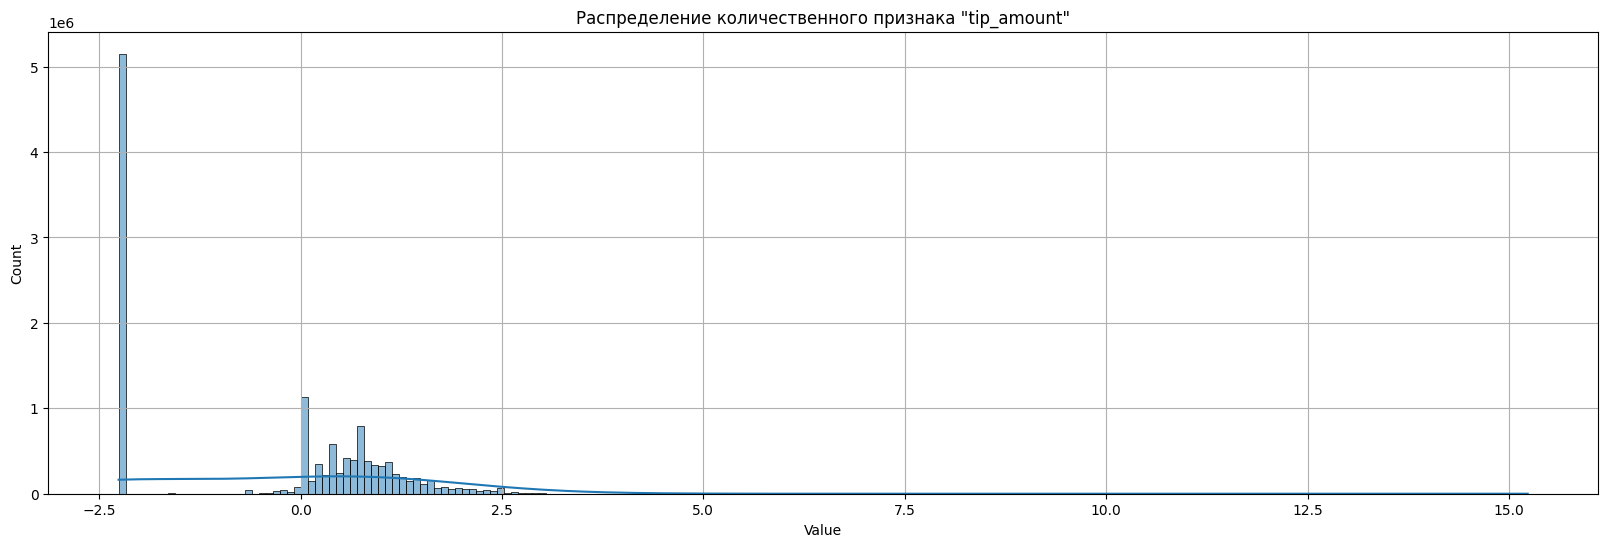

In [ ]:
# tip_amount - количественный признак
count_nulls(data = df, column_name = "tip_amount")

# проверим на выбросы
plot_boxplots(data=df, columns=["tip_amount"])

# 
df = df.withColumn(
    "tip_amount",
    when(col("tip_amount") < 0.1, 0.1)
        .otherwise(col("tip_amount"))
)

# логарифмируем
df = df.withColumn("tip_amount", log(col("tip_amount")))
count_nulls(data = df, column_name = "tip_amount")
df = df.filter(df.tip_amount.isNotNull())

# удалим выбросы
#df = df.withColumn(
#    "tip_amount",
#    when(col("tip_amount") > 2.0, 2.0)
#        .otherwise(col("tip_amount"))
#)



# визуализируем распределение
plot_quant_distribution(data=df, column="tip_amount")

#### Анализ столбца `tolls_amount`

`tolls_amount` - Количественный признак.
Проверим на выбросы и пропущенные значения. Избавимся от выбросов.

Визуализируем распределение.

Число колонок с NULL: 0 (0.00%)


Минимальное значение:          0.00
Среднее значение:              0.24
Среднеквадратичное отклонение: 1.46
Первый квартиль:               0.00
Медиана:                       0.00
Третий квартиль:               0.00
Максимальное значение:         1450.09


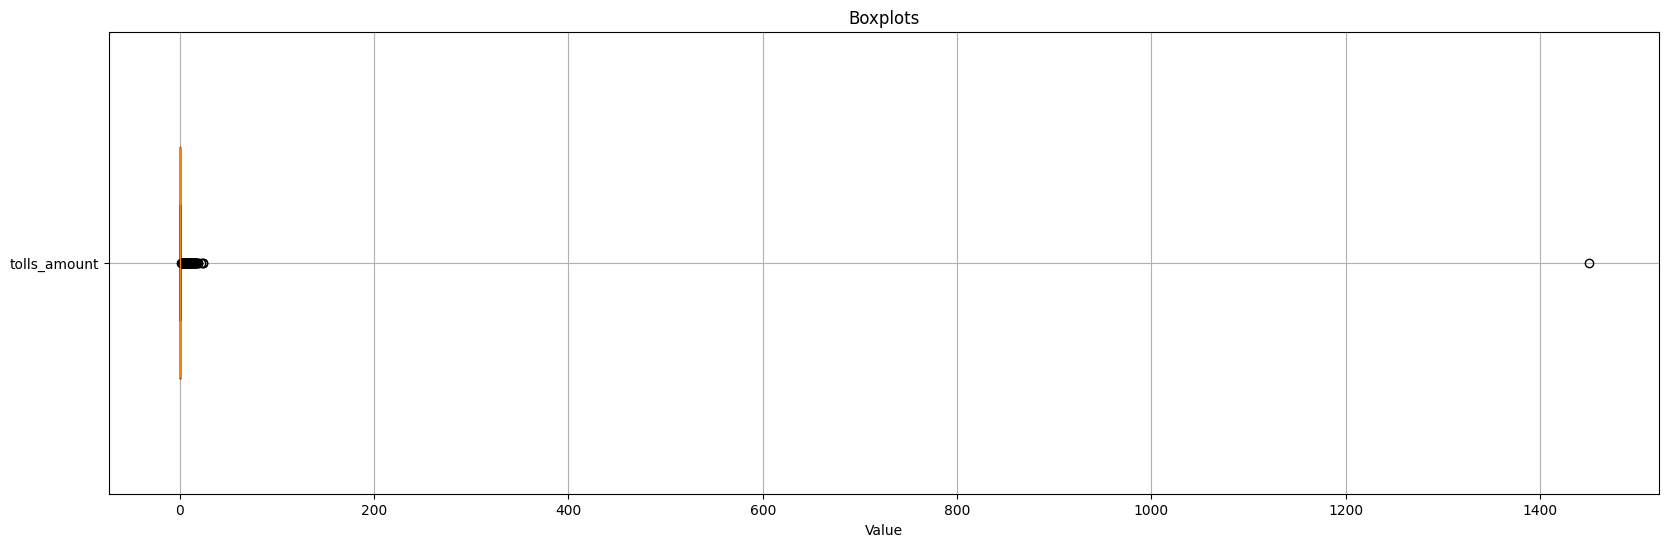

Количество категорий признака tolls_amount: 2


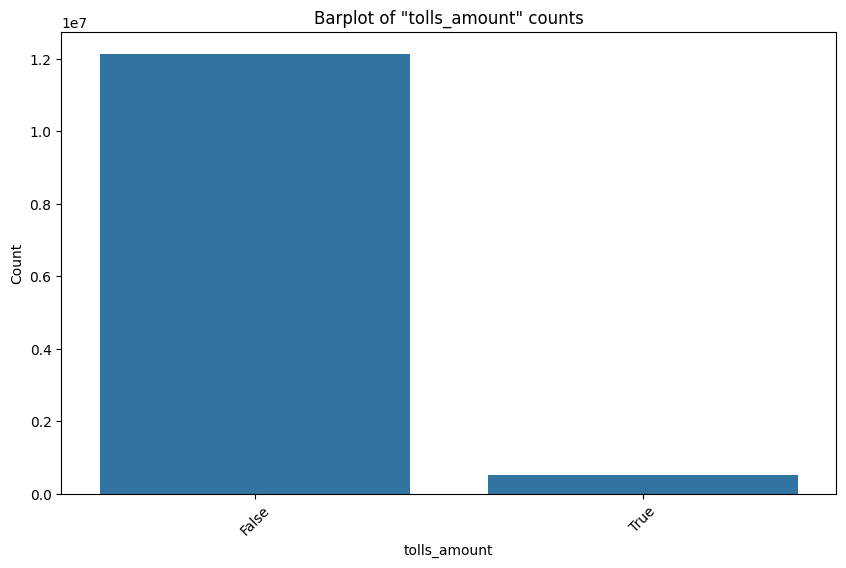

In [89]:
# Бинаризовать

# tolls_amount - количественный признак
count_nulls(data = df, column_name = "tolls_amount")

# проверим на выбросы
plot_boxplots(data=df, columns=["tolls_amount"])

# удалим выбросы
df = df.withColumn(
    "tolls_amount",
    when(col("tolls_amount") > 0.1, True)
        .otherwise(False)
)

# визуализируем распределение
plot_cat_distribution(df, "tolls_amount")

#### Анализ столбца `improvement_surcharge`

`improvement_surcharge` - Количественный признак.
Проверим на выбросы и пропущенные значения. Избавимся от выбросов.

Визуализируем распределение.

Число колонок с NULL: 3 (0.00%)


Минимальное значение:          0.00
Среднее значение:              0.28
Среднеквадратичное отклонение: 0.07
Первый квартиль:               0.30
Медиана:                       0.30
Третий квартиль:               0.30
Максимальное значение:         0.30


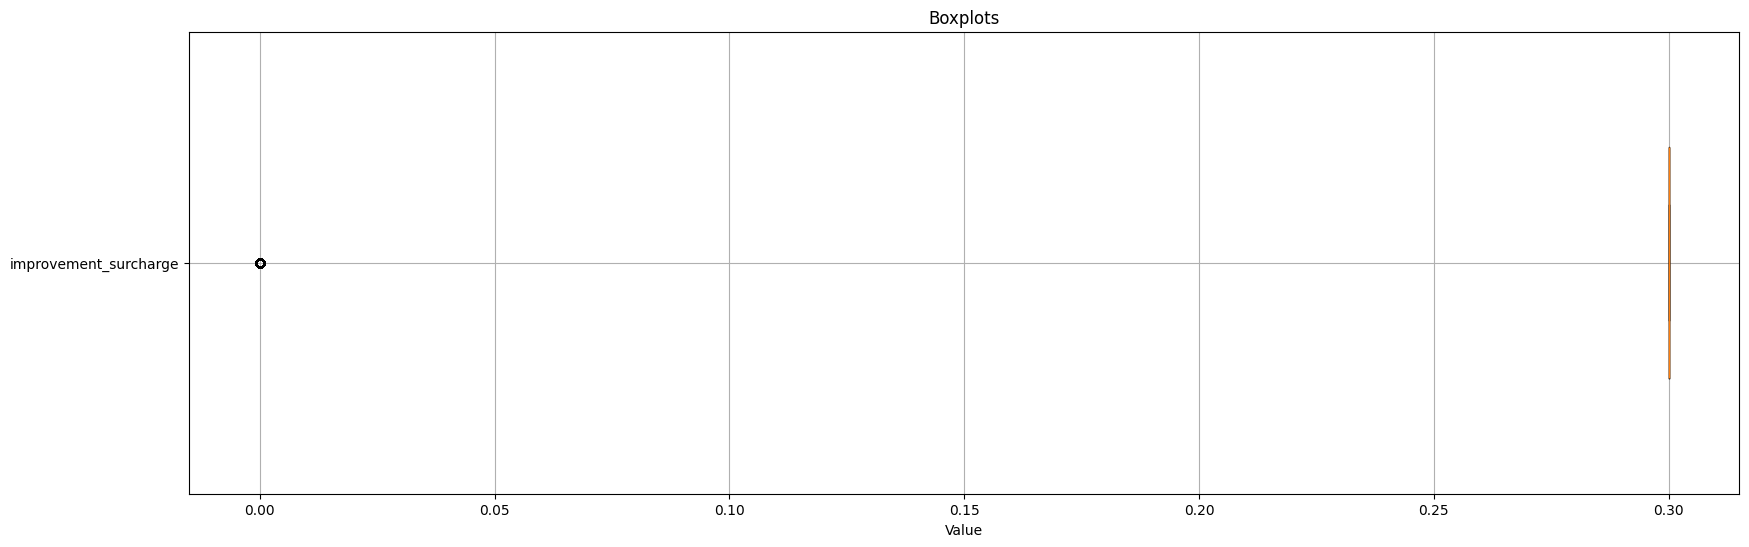

Количество категорий признака improvement_surcharge: 2


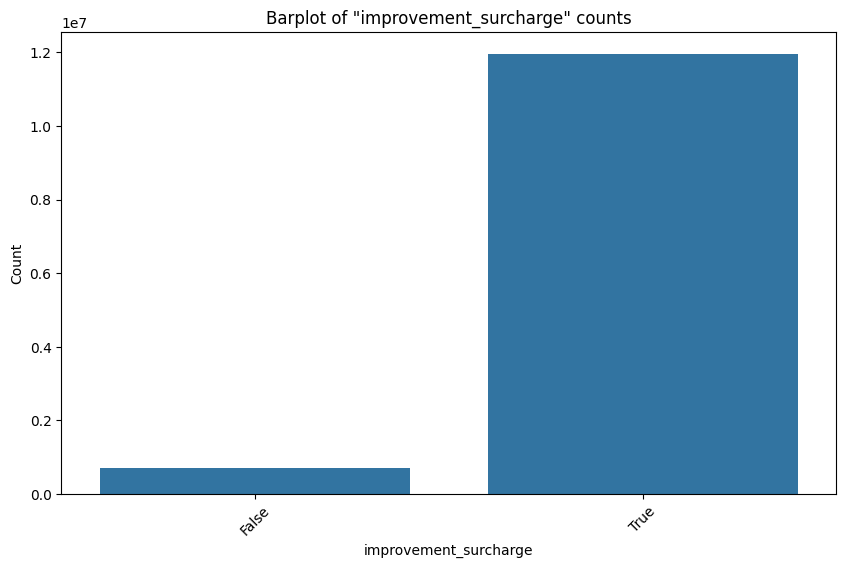

In [90]:
# improvement_surcharge - количественный признак
count_nulls(data = df, column_name = "improvement_surcharge")
df = df.fillna({'improvement_surcharge':'0.28'})

# проверим на выбросы
plot_boxplots(data=df, columns=["improvement_surcharge"])

# удалим выбросы
df = df.withColumn(
    "improvement_surcharge",
    when(col("improvement_surcharge") > 0.29, True)
        .otherwise(False)
)

# визуализируем распределение
plot_cat_distribution(df, "improvement_surcharge")

#### Анализ столбца `total_amount`

`total_amount` - Количественный признак.
Проверим на выбросы и пропущенные значения. Избавимся от выбросов.

Визуализируем распределение.

Число колонок с NULL: 0 (0.00%)


Минимальное значение:          -69.70
Среднее значение:              15.07
Среднеквадратичное отклонение: 1110.20
Первый квартиль:               8.30
Медиана:                       11.30
Третий квартиль:               16.30
Максимальное значение:         3950611.50


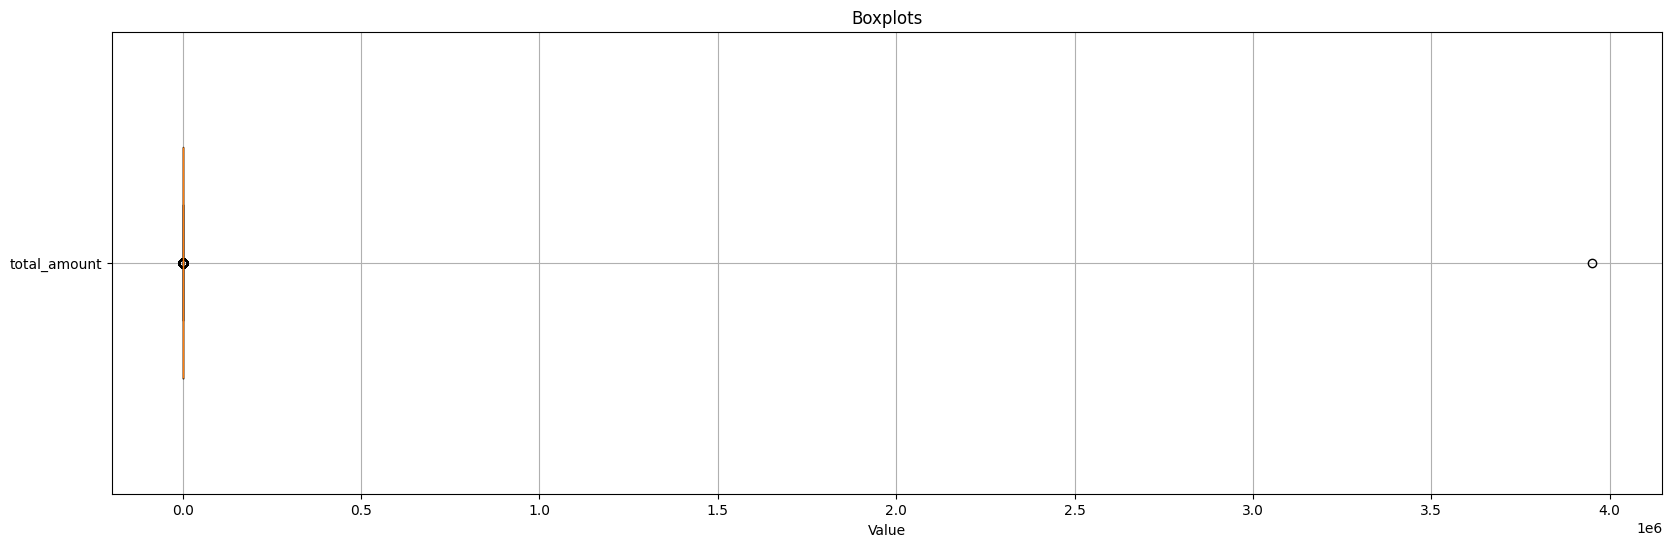

Число колонок с NULL: 0 (0.00%)


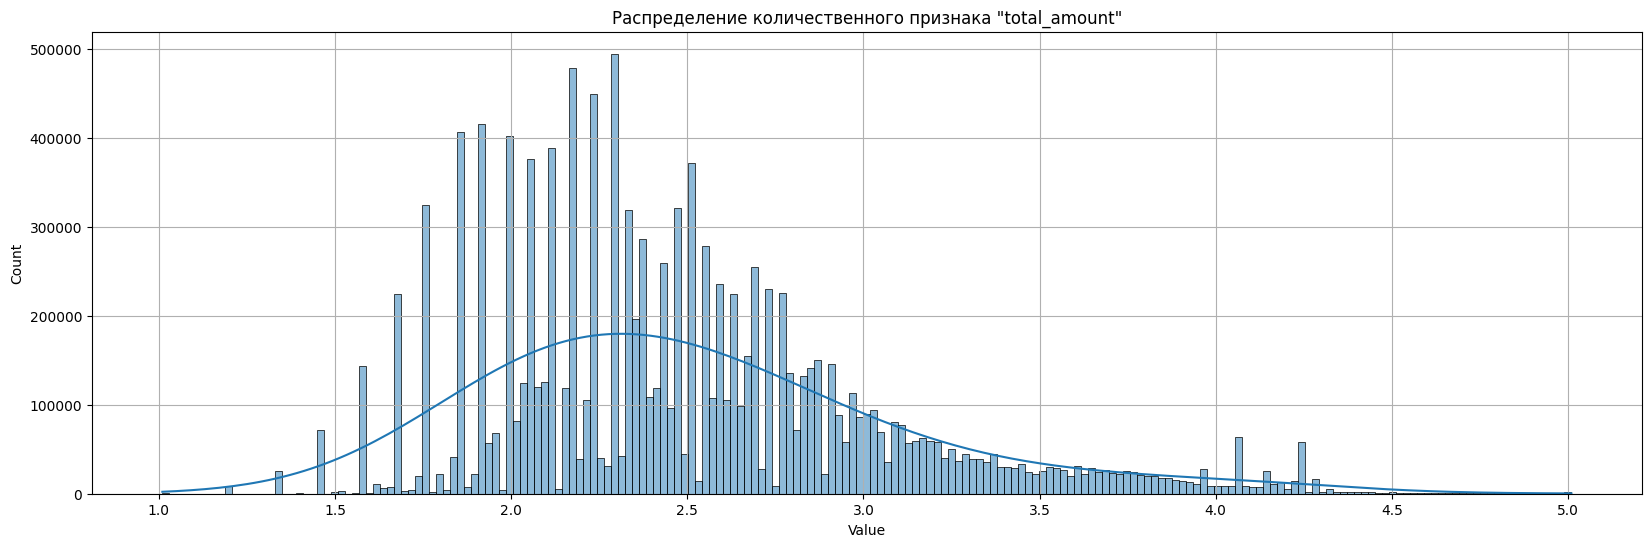

In [91]:
# total_amount - количественный признак
count_nulls(data = df, column_name = "total_amount")

# проверим на выбросы
plot_boxplots(data=df, columns=["total_amount"])

# удалим выбросы
df = df.withColumn(
    "total_amount",
    when(col("total_amount") < 2.0, 2.0)
        .otherwise(col("total_amount"))
)

# логарифмируем
df = df.withColumn("total_amount", log(col("total_amount")))
count_nulls(data = df, column_name = "total_amount")
df = df.filter(df.total_amount.isNotNull())

# удалим выбросы
df = df.withColumn(
    "total_amount",
    when(col("total_amount") < 1.0, 1.0)
        .otherwise(col("total_amount"))
)

df = df.withColumn(
    "total_amount",
    when(col("total_amount") > 5.0, 5.0)
        .otherwise(col("total_amount"))
)

# визуализируем распределение
plot_quant_distribution(data=df, column="total_amount")

In [92]:
df.show()

+--------+--------------------+---------------------+---------------+--------------------+----------+------------------+------------+------------------+----------+------------+---------------------+------------------+------------+-------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|       trip_distance|RateCodeID|store_and_fwd_flag|payment_type|       fare_amount|tip_amount|tolls_amount|improvement_surcharge|      total_amount|is_pickup_NY|is_dropoff_NY|
+--------+--------------------+---------------------+---------------+--------------------+----------+------------------+------------+------------------+----------+------------+---------------------+------------------+------------+-------------+
|       2|          1421345922|        1.421346245E9|              6|-0.05129330693589688|      true|                 N|           1|1.7047480922384253|       1.5|       false|                 true| 2.116255537782656|        true|         true|
|       2|          

In [93]:
df.count()

12664005

In [94]:
df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: long (nullable = true)
 |-- tpep_dropoff_datetime: double (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RateCodeID: boolean (nullable = false)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- tip_amount: float (nullable = true)
 |-- tolls_amount: boolean (nullable = false)
 |-- improvement_surcharge: boolean (nullable = false)
 |-- total_amount: double (nullable = true)
 |-- is_pickup_NY: boolean (nullable = false)
 |-- is_dropoff_NY: boolean (nullable = false)



#### Расчет корреляции между количественными признаками

In [98]:
def compute_and_visualize_correlation_matrix(data: DataFrame, 
                                             columns: list[str]) -> None:
    """
    Вычисляет и визуализирует корреляционную матрицу для указанных 
    колонок в DataFrame PySpark.

    Args:
        df (DataFrame): DataFrame PySpark.
        columns (list[str]): Список колонок для вычисления корреляции.

    Returns:
        None
    """
    # Вычисление корреляционной матрицы
    corr_matrix = {}
    for col1 in columns:
        corr_matrix[col1] = {}
        for col2 in columns:
            corr_value = data.select(corr(col1, col2)).collect()[0][0]
            corr_matrix[col1][col2] = corr_value

    # Преобразование корреляционной матрицы в DataFrame Pandas для визуализации
    corr_matrix_pd = pd.DataFrame(corr_matrix)

    # Построение и визуализация корреляционной матрицы
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix_pd, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.show()

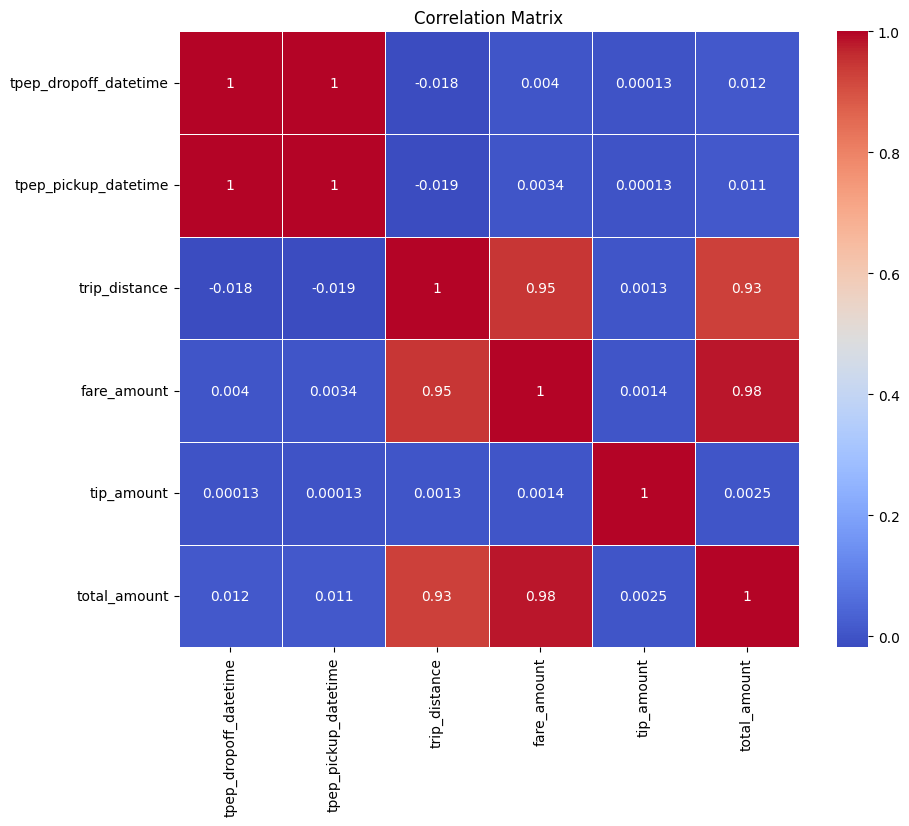

In [99]:
compute_and_visualize_correlation_matrix(
    data=df, columns=[
        "tpep_dropoff_datetime", "tpep_pickup_datetime", "trip_distance",
        "fare_amount", "tip_amount", "total_amount"
    ]
)

Корреляционная матрица демонстрирует наличие корреляции между некоторыми количественными признаками.

Посмотрим, сколько объектов осталось после преобразований датасета.

In [100]:
df.count()

12664005

In [ ]:
df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: long (nullable = true)
 |-- tpep_dropoff_datetime: double (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RateCodeID: boolean (nullable = false)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- tip_amount: float (nullable = true)
 |-- tolls_amount: boolean (nullable = false)
 |-- improvement_surcharge: boolean (nullable = false)
 |-- total_amount: double (nullable = true)
 |-- is_pickup_NY: boolean (nullable = false)
 |-- is_dropoff_NY: boolean (nullable = false)



Сохраняет очищенную и обработанную таблицу на диск.

In [101]:
# Сохранение DataFrame в виде таблицы
spark.sql("DROP TABLE spark_catalog.skobelin_database.skobelin_lab1_processed_table")
df.writeTo("skobelin_lab1_processed_table").using("iceberg").create()

In [102]:
for table in spark.catalog.listTables():
    print(table.name)

skobelin_lab1_processed_table
skobelin_lab1_table


Обратите внимание, что при необходимости созданные базу данных и таблицу можно удалить следующими командами.

In [ ]:
spark.sql("DROP TABLE spark_catalog.skobelin_database.skobelin_lab1_processed_table")
spark.sql("DROP DATABASE spark_catalog.ivanov_database")

Останавливаем `Spark`-сессию.

In [103]:
spark.stop()